# PROJECT 2: Part 2 - Web Scrape and Analysis
### Paulina Mostek
### Objective: Setup a web scraping pipeline to scrape data from at least five pages from https://www.basketball-reference.com/. 
* Place the data in a pandas DataFrame,
* Clean the data, if necessary
* Perform data analysis that answers a minimum of four questions about the data.
* Answers should be given programmatically as output and at least two questions should have answers demonstrated via a plot, utilizing Seaborn.
* Plot analysis should include data labels, and a title that summarizes your conclusion, and styling should be applied.
* Restriction: Crawl/request delay of 3 seconds must be followed as per robots.txt on basketball-reference.com.

### We will scrape data to answer the following questions:
1. How has LeBron James’ scoring efficiency (TS%, PER) changed over the last 10 years?
2. Which teams in the eastern conference had the best win-lose percentage and how does it correlate with opponent points per game?
3. In the 2024-25 season, how does the Lakers' performance compare to their opponents? Judge stats like field goal percentage, total rebounds, and total points.
4. Which coaches of the 2024-2025 season had the highest win ratio?
5. What impact do the Round 1 2024 draft members with the top 10 points-per-game have on their team wins? Assess points per game (PTS), assists (AST), and win shares (WS) among the top 10 points-per-game draft players. 


### We will be using the following webpages:
1. Lakers 2024-25 Season https://www.basketball-reference.com/teams/LAL/2025.html
2. 2024-25 Season Summary (includes Eastern Conference) https://www.basketball-reference.com/leagues/NBA_2025.html
3. Lebron: https://www.basketball-reference.com/players/j/jamesle01.html
4. 2024-2025 Coaches: https://www.basketball-reference.com/leagues/NBA_2025_coaches.html
5. 2024 NBA Draft: https://www.basketball-reference.com/draft/NBA_2024.html

## Citation:
* cloudscraper library is imported from Python Project: https://pypi.org/project/cloudscraper/
* This library was used to bypass anti-bot pages in order to successfully perform webscraping.

# <u>Imports</u>
## Import libraries
* Requests: Allows webpages to be pulled
* Pandas: Allows for dataframe manipulation
* Time: Allows for crawl/request delay in order to abide by robots.txt of website we are pulling from
* Seaborns: Used for plotting
* BeautifulSoup: Allows for webscraping
* matplotlib.pyplot and numpy: Allows for plotting of data
* <u>cloudscraper:</u> Used to scrape data since BeautifulSoup results in 403 error (<u>Credit: Python Project</u> https://pypi.org/)
* re: Used for regular expressions (regex) to manipulate strings

In [66]:
import requests
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import cloudscraper
from bs4 import BeautifulSoup, Comment
import re

## Use seaborn styling for plotting

In [9]:
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# <u>Set up web-scraping pipeline</u>
* Define headers to simulate a browser request, so that our request does not get mistaken for a bot and denied access to the webpage.
* Define the webpages (URLs) that we will be searching so that we do not have to manually access them
* Define a crawl delay (3 seconds) so that we can easily implement the delay using a variable. This is so that our requests do not overload the webpage.
* Define function to scrape a table by id

### Define headers

In [10]:
#Headers to simulate a browser request
HEADERS = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"
}


### Define URLs

In [11]:
#URLs
URLS = {
    "season_summary": "https://www.basketball-reference.com/leagues/NBA_2025.html",
    "lakers_2024": "https://www.basketball-reference.com/teams/LAL/2024.html",
    "lakers_2025": "https://www.basketball-reference.com/teams/LAL/2025.html",
    "lebron_stats": "https://www.basketball-reference.com/players/j/jamesle01.html",
    "coaches": "https://www.basketball-reference.com/leagues/NBA_2025_coaches.html",
    "draft_2024": "https://www.basketball-reference.com/draft/NBA_2024.html"
}

### Define crawl delay (set as a constant so that we know this value does not change)

In [12]:
#Crawl delay per robots.txt
CRAWL_DELAY = 3

### Define scraper
* Create a scraper to webscrape data using the cloudscraper and assign it to the variable "scraper" to be used in the pipeline
* Cloudscraper library imported from Python Project (https://pypi.org/)

In [37]:
scraper = cloudscraper.create_scraper()

### Define function to scrape a table by id, using BeautifulSoup
#### Table id's are hidden inside comments in the HTML code of the website. We must use BeautifulSoup to extract the tables.
* Utilize the url and table id
* Utilize the crawl delay to wait between requests
* Utilize the headers to simulate a browser request
* Read the webpage for tables
* Return the found tables

In [259]:
def get_table_from_url(url, table_id):
    time.sleep(CRAWL_DELAY)  # respect crawl delay
    response = scraper.get(url)
    html = response.text

    #Parse with BeautifulSoup
    soup = BeautifulSoup(html, "html.parser")

    #Try to find table normally first
    table = soup.find("table", id=table_id)
    if table:
        df = pd.read_html(str(table))[0]
        return df

    #If not found, search inside comments (some Basketball Reference tables are inside HTML comments)
    comments = soup.find_all(string=lambda text: isinstance(text, Comment))
    for comment in comments:
        try:
            comment_soup = BeautifulSoup(comment, "html.parser")
            table = comment_soup.find("table", id=table_id)
            if table:
                df = pd.read_html(str(table))[0]
                return df
        except Exception as e:
            print(f"Error parsing comment for table '{table_id}': {e}")

    raise ValueError(f"Table with id '{table_id}' not found in {url}")

# <u>Function that uses caption id</u>

In [50]:
def get_table_by_caption(url, caption_text):
    time.sleep(CRAWL_DELAY)
    response = requests.get(url, headers=HEADERS)
    html = response.text

    soup = BeautifulSoup(html, "html.parser")

    # Search visible tables first
    tables = soup.find_all("table")
    for table in tables:
        caption = table.find("caption")
        if caption and caption_text.lower() in caption.text.lower():
            return pd.read_html(str(table))[0]

    # Search tables inside comments (hidden tables)
    comments = soup.find_all(string=lambda text: isinstance(text, Comment))
    for comment in comments:
        try:
            comment_soup = BeautifulSoup(comment, "html.parser")
            tables = comment_soup.find_all("table")
            for table in tables:
                caption = table.find("caption")
                if caption and caption_text.lower() in caption.text.lower():
                    return pd.read_html(str(table))[0]
        except Exception as e:
            print(f"Error parsing comment block: {e}")

    raise ValueError(f"Table with caption '{caption_text}' not found in {url}")

### Debug
* Tables are hidden in HTML comments, which are retrieved with the cloudscraper
* Sometimes, incorrect table id's are used and retrieve error as id's are case-sensitive
* These commands check if those table id's are in the webpage.
* If the result is true, the table id is correct.
* If the result is false, the table id is incorrect (possibly an issue of one letter being uppercase)

In [33]:
scraper = cloudscraper.create_scraper()  #returns a CloudScraper instance
url = "https://www.basketball-reference.com/leagues/NBA_2025_coaches.htmll"
html = scraper.get(url).text

print("Length of HTML:", len(html))
print("'NBA_Coaches' found in HTML?", "per_game-team" in html)

Length of HTML: 768113
'per_game-team' found in HTML? True


# <u>Part 1: Scrape All Relevant Tables</u>
## Scrape <u>2024 season summary</u> (https://www.basketball-reference.com/leagues/NBA_2025.html)
* Per-game table: <u>season_per_game</u>
* Advanced table: <u>season_advanced</u>
* Eastern Conference table: <u>eastern_conference</u>
### Inspect all scraped tables to determine if further cleaning is needed
* View table
* View datatypes with .dtypes
* View columns with .columns

### Per-game table: <u>season_per_game</u>

In [70]:
season_per_game = get_table_from_url(URLS['season_summary'], "per_game-team")

C:\Users\pmost\AppData\Local\Temp\ipykernel_18404\2437300910.py:12: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


1. Inspect table

In [71]:
season_per_game

,Rk,Team,G,MP,FG,FGA,FG%,3P,3PA,3P%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1.0,Cleveland Cavaliers*,82,240.9,44.5,90.8,0.491,15.9,41.5,0.383,...,0.776,11.2,34.2,45.4,28.1,8.2,4.3,13.2,18.1,121.9
1,2.0,Memphis Grizzlies*,82,240.3,44.8,93.3,0.479,13.9,37.9,0.367,...,0.786,12.9,34.4,47.3,28.4,8.9,5.6,15.7,20.9,121.7
2,3.0,Denver Nuggets*,82,242.1,45.4,89.8,0.506,12.0,31.9,0.376,...,0.770,11.2,34.5,45.7,31.0,8.0,4.9,14.3,17.6,120.8
3,4.0,Oklahoma City Thunder*,82,240.3,44.6,92.7,0.482,14.5,38.8,0.374,...,0.819,10.6,34.2,44.8,26.9,10.3,5.7,11.7,19.9,120.5
4,5.0,Atlanta Hawks,82,241.2,43.4,91.8,0.472,13.5,37.7,0.358,...,0.775,11.9,32.6,44.5,29.6,9.7,5.1,15.5,19.1,118.2
5,6.0,Chicago Bulls,82,240.9,43.2,92.0,0.470,15.4,42.0,0.367,...,0.809,10.1,35.8,45.9,29.1,7.6,4.7,14.7,17.6,117.8
6,7.0,Indiana Pacers*,82,242.1,43.6,89.3,0.488,13.2,35.8,0.368,...,0.789,9.2,32.7,41.8,29.2,8.5,5.5,13.2,18.7,117.4
7,8.0,Boston Celtics*,82,241.8,41.6,90.0,0.462,17.8,48.2,0.368,...,0.799,11.4,33.9,45.3,26.1,7.2,5.5,11.9,15.9,116.3
8,9.0,New York Knicks*,82,242.4,43.3,89.2,0.486,12.6,34.1,0.369,...,0.800,10.9,31.8,42.6,27.5,8.2,4.0,13.3,17.2,115.8
9,10.0,Sacramento Kings,82,242.4,43.0,90.1,0.478,12.6,35.2,0.357,...,0.806,11.0,33.2,44.2,26.5,7.6,4.4,13.3,18.9,115.7


2. Inspect data types
* Result: all data types are as expected. Team name is an object (string). All numerical stats are decimals (float64).

In [72]:
season_per_game.dtypes

Rk      float64
Team     object
G         int64
MP      float64
FG      float64
FGA     float64
FG%     float64
3P      float64
3PA     float64
3P%     float64
2P      float64
2PA     float64
2P%     float64
FT      float64
FTA     float64
FT%     float64
ORB     float64
DRB     float64
TRB     float64
AST     float64
STL     float64
BLK     float64
TOV     float64
PF      float64
PTS     float64
dtype: object

3. View columns
* Result: Column names are as expected with no whitespace
* Data appears to be clean enough to use as-is

In [73]:
season_per_game.columns

Index(['Rk', 'Team', 'G', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P',
       '2PA', '2P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'PTS'],
      dtype='object')

### Advanced table: <u>season_advanced</u>

In [74]:
season_advanced = get_table_from_url(URLS['season_summary'], "advanced-team")

C:\Users\pmost\AppData\Local\Temp\ipykernel_18404\2437300910.py:12: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


1. Inspect table

In [58]:
season_advanced

Unnamed: 0_level_0       Unnamed: 1_level_0 Unnamed: 2_level_0  \
                   Rk                     Team                Age   
0                 1.0   Oklahoma City Thunder*               24.8   
1                 2.0          Boston Celtics*               28.9   
2                 3.0     Cleveland Cavaliers*               26.6   
3                 4.0  Minnesota Timberwolves*               27.2   
4                 5.0    Los Angeles Clippers*               29.7   
5                 6.0       Memphis Grizzlies*               24.7   
6                 7.0         Houston Rockets*               24.9   
7                 8.0         New York Knicks*               27.5   
8                 9.0          Denver Nuggets*               27.0   
9                10.0   Golden State Warriors*               28.6   
10               11.0         Milwaukee Bucks*               29.3   
11               12.0          Indiana Pacers*               25.8   
12               13.0         Detroit Pistons*               25.8   
13               14.0      Los Angeles Lakers*               27.9   
14               15.0              Miami Heat*               26.8   
15               16.0         Sacramento Kings               27.8   
16               17.0           Orlando Magic*               24.9   
17               18.0            Atlanta Hawks               24.9   
18               19.0         Dallas Mavericks               27.5   
19               20.0            Chicago Bulls               25.2   
20               21.0        San Antonio Spurs               26.0   
21               22.0   Portland Trail Blazers               23.8   
22               23.0             Phoenix Suns               29.1   
23               24.0          Toronto Raptors               24.5   
24               25.0       Philadelphia 76ers               27.1   
25               26.0            Brooklyn Nets               24.7   
26               27.0                Utah Jazz               23.9   
27               28.0        Charlotte Hornets               25.1   
28               29.0     New Orleans Pelicans               25.9   
29               30.0       Washington Wizards               23.5   
30                NaN           League Average               26.5   

   Unnamed: 3_level_0 Unnamed: 4_level_0 Unnamed: 5_level_0  \
                    W                  L                 PW   
0                68.0               14.0                 68   
1                61.0               21.0                 62   
2                64.0               18.0                 62   
3                49.0               33.0                 53   
4                50.0               32.0                 53   
5                48.0               34.0                 52   
6                52.0               30.0                 52   
7                51.0               31.0                 51   
8                50.0               32.0                 50   
9                48.0               34.0                 49   
10               48.0               34.0                 47   
11               50.0               32.0                 46   
12               44.0               38.0                 46   
13               50.0               32.0                 44   
14               37.0               45.0                 42   
15               40.0               42.0                 42   
16               41.0               41.0                 41   
17               40.0               42.0                 38   
18               39.0               43.0                 38   
19               39.0               43.0                 37   
20               34.0               48.0                 34   
21               36.0               46.0                 33   
22               36.0               46.0                 34   
23               30.0               52.0                 30   
24               24.0               58.0                 26   
25               26.0   

## Observation: A multi-level index of headers exists.
1. Missing values exist. Entire columns may be missing as they serve as placeholders or borders in the table (visual markers).
2. Categories exist
3. This data should be flattened for easier access

* View raw column names with .columns
* Result: MultiIndex exists

In [75]:
season_advanced.columns

MultiIndex([(  'Unnamed: 0_level_0',                  'Rk'),
            (  'Unnamed: 1_level_0',                'Team'),
            (  'Unnamed: 2_level_0',                 'Age'),
            (  'Unnamed: 3_level_0',                   'W'),
            (  'Unnamed: 4_level_0',                   'L'),
            (  'Unnamed: 5_level_0',                  'PW'),
            (  'Unnamed: 6_level_0',                  'PL'),
            (  'Unnamed: 7_level_0',                 'MOV'),
            (  'Unnamed: 8_level_0',                 'SOS'),
            (  'Unnamed: 9_level_0',                 'SRS'),
            ( 'Unnamed: 10_level_0',                'ORtg'),
            ( 'Unnamed: 11_level_0',                'DRtg'),
            ( 'Unnamed: 12_level_0',                'NRtg'),
            ( 'Unnamed: 13_level_0',                'Pace'),
            ( 'Unnamed: 14_level_0',                 'FTr'),
            ( 'Unnamed: 15_level_0',                '3PAr'),
            ( 'Unnamed: 

### Immediate data cleaning: Flatten multi-index

In [76]:
# Flatten MultiIndex columns by joining levels with "_" and replace 'Unnamed' with empty string to clean names
season_advanced.columns = [
    '_'.join(filter(None, [str(i).strip() for i in col])).replace("Unnamed_", "").strip('_')
    for col in season_advanced.columns.values
]


#### Check table again
* General overview
* Columns

In [77]:
season_advanced

,Unnamed: 0_level_0_Rk,Unnamed: 1_level_0_Team,Unnamed: 2_level_0_Age,Unnamed: 3_level_0_W,Unnamed: 4_level_0_L,Unnamed: 5_level_0_PW,Unnamed: 6_level_0_PL,Unnamed: 7_level_0_MOV,Unnamed: 8_level_0_SOS,Unnamed: 9_level_0_SRS,...,Offense Four Factors_FT/FGA,Unnamed: 22_level_0_Unnamed: 22_level_1,Defense Four Factors_eFG%,Defense Four Factors_TOV%,Defense Four Factors_DRB%,Defense Four Factors_FT/FGA,Unnamed: 27_level_0_Unnamed: 27_level_1,Unnamed: 28_level_0_Arena,Unnamed: 29_level_0_Attend.,Unnamed: 30_level_0_Attend./G
0,1.0,Oklahoma City Thunder*,24.8,68.0,14.0,68,14,12.87,-0.16,12.70,...,0.180,NaN,0.513,14.9,74.6,0.211,NaN,Paycom Center,754832,17973
1,2.0,Boston Celtics*,28.9,61.0,21.0,62,20,9.11,-0.83,8.28,...,0.169,NaN,0.522,11.6,76.0,0.154,NaN,TD Garden,785396,19156
2,3.0,Cleveland Cavaliers*,26.6,64.0,18.0,62,20,9.54,-0.73,8.81,...,0.187,NaN,0.528,12.6,74.8,0.181,NaN,Rocket Arena,796712,19432
3,4.0,Minnesota Timberwolves*,27.2,49.0,33.0,53,29,5.00,0.15,5.15,...,0.196,NaN,0.532,13.2,75.1,0.178,NaN,Target Center,772249,18835
4,5.0,Los Angeles Clippers*,29.7,50.0,32.0,53,29,4.66,0.18,4.84,...,0.200,NaN,0.536,13.7,77.5,0.189,NaN,Intuit Dome,679593,16575
5,6.0,Memphis Grizzlies*,24.7,48.0,34.0,52,30,4.85,-0.06,4.79,...,0.196,NaN,0.533,12.9,74.9,0.206,NaN,FedEx Forum,683067,16660
6,7.0,Houston Rockets*,24.9,52.0,30.0,52,30,4.51,0.45,4.97,...,0.178,NaN,0.528,12.8,76.2,0.186,NaN,Toyota Center,716853,17484
7,8.0,New York Knicks*,27.5,51.0,31.0,51,31,4.10,-0.51,3.59,...,0.186,NaN,0.549,13.1,74.5,0.176,NaN,Madison Square Garden (IV),811794,19800
8,9.0,Denver Nuggets*,27.0,50.0,32.0,50,32,3.89,0.08,3.97,...,0.200,NaN,0.542,11.3,74.6,0.173,NaN,Ball Arena,811211,19786
9,10.0,Golden State Warriors*,28.6,48.0,34.0,49,33,3.30,0.25,3.56,...,0.187,NaN,0.541,14.1,75.6,0.189,NaN,Chase Center,740624,18064


In [78]:
season_advanced.columns

Index(['Unnamed: 0_level_0_Rk', 'Unnamed: 1_level_0_Team',
       'Unnamed: 2_level_0_Age', 'Unnamed: 3_level_0_W',
       'Unnamed: 4_level_0_L', 'Unnamed: 5_level_0_PW',
       'Unnamed: 6_level_0_PL', 'Unnamed: 7_level_0_MOV',
       'Unnamed: 8_level_0_SOS', 'Unnamed: 9_level_0_SRS',
       'Unnamed: 10_level_0_ORtg', 'Unnamed: 11_level_0_DRtg',
       'Unnamed: 12_level_0_NRtg', 'Unnamed: 13_level_0_Pace',
       'Unnamed: 14_level_0_FTr', 'Unnamed: 15_level_0_3PAr',
       'Unnamed: 16_level_0_TS%', 'Unnamed: 17_level_0_Unnamed: 17_level_1',
       'Offense Four Factors_eFG%', 'Offense Four Factors_TOV%',
       'Offense Four Factors_ORB%', 'Offense Four Factors_FT/FGA',
       'Unnamed: 22_level_0_Unnamed: 22_level_1', 'Defense Four Factors_eFG%',
       'Defense Four Factors_TOV%', 'Defense Four Factors_DRB%',
       'Defense Four Factors_FT/FGA',
       'Unnamed: 27_level_0_Unnamed: 27_level_1', 'Unnamed: 28_level_0_Arena',
       'Unnamed: 29_level_0_Attend.', 'Unnamed: 30_le

### Observation: non-grouped columns contain "Unnamed: n_level_0". 
* Success: Multi-index has been flattened to a simple index.
* Improvements: "Unnamed: n_" should be droped to simplify column names.

### Data Cleaning: Clean column names
* Remove prefix "Unnamed: n__level_0" from all column names.
* View data
* View raw column names with .columns

#### 1. Remove prefix of column names
* Remove the "Unnamed: n_level_0_" pattern using Regular Expressions (regex)

In [82]:
#Remove only the prefix "Unnamed: n_level_0_" if it exists
season_advanced.columns = [
    re.sub(r"^Unnamed: \d+_level_0_", "", col)
    for col in season_advanced.columns
]

### View data for changes
* View data
* View raw column names with .columns
* View data types with .dtypes

In [84]:
season_advanced

,Rk,Team,Age,W,L,PW,PL,MOV,SOS,SRS,...,Offense Four Factors_FT/FGA,Unnamed: 22_level_1,Defense Four Factors_eFG%,Defense Four Factors_TOV%,Defense Four Factors_DRB%,Defense Four Factors_FT/FGA,Unnamed: 27_level_1,Arena,Attend.,Attend./G
0,1.0,Oklahoma City Thunder*,24.8,68.0,14.0,68,14,12.87,-0.16,12.70,...,0.180,NaN,0.513,14.9,74.6,0.211,NaN,Paycom Center,754832,17973
1,2.0,Boston Celtics*,28.9,61.0,21.0,62,20,9.11,-0.83,8.28,...,0.169,NaN,0.522,11.6,76.0,0.154,NaN,TD Garden,785396,19156
2,3.0,Cleveland Cavaliers*,26.6,64.0,18.0,62,20,9.54,-0.73,8.81,...,0.187,NaN,0.528,12.6,74.8,0.181,NaN,Rocket Arena,796712,19432
3,4.0,Minnesota Timberwolves*,27.2,49.0,33.0,53,29,5.00,0.15,5.15,...,0.196,NaN,0.532,13.2,75.1,0.178,NaN,Target Center,772249,18835
4,5.0,Los Angeles Clippers*,29.7,50.0,32.0,53,29,4.66,0.18,4.84,...,0.200,NaN,0.536,13.7,77.5,0.189,NaN,Intuit Dome,679593,16575
5,6.0,Memphis Grizzlies*,24.7,48.0,34.0,52,30,4.85,-0.06,4.79,...,0.196,NaN,0.533,12.9,74.9,0.206,NaN,FedEx Forum,683067,16660
6,7.0,Houston Rockets*,24.9,52.0,30.0,52,30,4.51,0.45,4.97,...,0.178,NaN,0.528,12.8,76.2,0.186,NaN,Toyota Center,716853,17484
7,8.0,New York Knicks*,27.5,51.0,31.0,51,31,4.10,-0.51,3.59,...,0.186,NaN,0.549,13.1,74.5,0.176,NaN,Madison Square Garden (IV),811794,19800
8,9.0,Denver Nuggets*,27.0,50.0,32.0,50,32,3.89,0.08,3.97,...,0.200,NaN,0.542,11.3,74.6,0.173,NaN,Ball Arena,811211,19786
9,10.0,Golden State Warriors*,28.6,48.0,34.0,49,33,3.30,0.25,3.56,...,0.187,NaN,0.541,14.1,75.6,0.189,NaN,Chase Center,740624,18064


In [85]:
season_advanced.columns

Index(['Rk', 'Team', 'Age', 'W', 'L', 'PW', 'PL', 'MOV', 'SOS', 'SRS', 'ORtg',
       'DRtg', 'NRtg', 'Pace', 'FTr', '3PAr', 'TS%', 'Unnamed: 17_level_1',
       'Offense Four Factors_eFG%', 'Offense Four Factors_TOV%',
       'Offense Four Factors_ORB%', 'Offense Four Factors_FT/FGA',
       'Unnamed: 22_level_1', 'Defense Four Factors_eFG%',
       'Defense Four Factors_TOV%', 'Defense Four Factors_DRB%',
       'Defense Four Factors_FT/FGA', 'Unnamed: 27_level_1', 'Arena',
       'Attend.', 'Attend./G'],
      dtype='object')

### Observation: Most Unnamed columns have been removed. The remaining unnamed columns appear to match the empty columns in the original table.
* Inspect each remaining Unnamed column to view if it is entirely missing
* Drop missing columns if needed

In [86]:
season_advanced["Unnamed: 17_level_1"]

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
5    NaN
6    NaN
7    NaN
8    NaN
9    NaN
10   NaN
11   NaN
12   NaN
13   NaN
14   NaN
15   NaN
16   NaN
17   NaN
18   NaN
19   NaN
20   NaN
21   NaN
22   NaN
23   NaN
24   NaN
25   NaN
26   NaN
27   NaN
28   NaN
29   NaN
30   NaN
Name: Unnamed: 17_level_1, dtype: float64

In [87]:
season_advanced["Unnamed: 22_level_1"]

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
5    NaN
6    NaN
7    NaN
8    NaN
9    NaN
10   NaN
11   NaN
12   NaN
13   NaN
14   NaN
15   NaN
16   NaN
17   NaN
18   NaN
19   NaN
20   NaN
21   NaN
22   NaN
23   NaN
24   NaN
25   NaN
26   NaN
27   NaN
28   NaN
29   NaN
30   NaN
Name: Unnamed: 22_level_1, dtype: float64

In [88]:
season_advanced["Unnamed: 27_level_1"]

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
5    NaN
6    NaN
7    NaN
8    NaN
9    NaN
10   NaN
11   NaN
12   NaN
13   NaN
14   NaN
15   NaN
16   NaN
17   NaN
18   NaN
19   NaN
20   NaN
21   NaN
22   NaN
23   NaN
24   NaN
25   NaN
26   NaN
27   NaN
28   NaN
29   NaN
30   NaN
Name: Unnamed: 27_level_1, dtype: float64

#### Observation: These 3 columns are entirely empty. They are simply placeholder columns to make the table appear more neat when viewing the website.
* Since they serve no purpose other than decoration, these columns will be deleted entirely

### Data cleaning: Find empty columns and drop them
1. Identify columns with all missing values using .isna()
2. Print column names where all values are empty (NaN)
3. Drop those columns
4. Check data again

In [89]:
#1: Identify columns with all missing values
all_nan_cols = [col for col in season_advanced.columns if season_advanced[col].isna().all()]

#2: Print them for verification
if all_nan_cols:
    print("Columns with all missing values:")
    for col in all_nan_cols:
        print(f" - {col}")
else:
    print("No columns with all missing values found.")

Columns with all missing values:
 - Unnamed: 17_level_1
 - Unnamed: 22_level_1
 - Unnamed: 27_level_1


* Confirmed: Previously identified columns are the only columns containing all missing values. These columns may now be dropped.

### Drop empty columns

In [90]:
season_advanced.drop(columns=all_nan_cols, inplace=True)

#### Check the data gain
1. View data
2. View columns
3. View dataypes

In [91]:
season_advanced

,Rk,Team,Age,W,L,PW,PL,MOV,SOS,SRS,...,Offense Four Factors_TOV%,Offense Four Factors_ORB%,Offense Four Factors_FT/FGA,Defense Four Factors_eFG%,Defense Four Factors_TOV%,Defense Four Factors_DRB%,Defense Four Factors_FT/FGA,Arena,Attend.,Attend./G
0,1.0,Oklahoma City Thunder*,24.8,68.0,14.0,68,14,12.87,-0.16,12.70,...,10.3,24.2,0.180,0.513,14.9,74.6,0.211,Paycom Center,754832,17973
1,2.0,Boston Celtics*,28.9,61.0,21.0,62,20,9.11,-0.83,8.28,...,10.8,25.7,0.169,0.522,11.6,76.0,0.154,TD Garden,785396,19156
2,3.0,Cleveland Cavaliers*,26.6,64.0,18.0,62,20,9.54,-0.73,8.81,...,11.6,25.9,0.187,0.528,12.6,74.8,0.181,Rocket Arena,796712,19432
3,4.0,Minnesota Timberwolves*,27.2,49.0,33.0,53,29,5.00,0.15,5.15,...,13.0,25.8,0.196,0.532,13.2,75.1,0.178,Target Center,772249,18835
4,5.0,Los Angeles Clippers*,29.7,50.0,32.0,53,29,4.66,0.18,4.84,...,13.4,24.4,0.200,0.536,13.7,77.5,0.189,Intuit Dome,679593,16575
5,6.0,Memphis Grizzlies*,24.7,48.0,34.0,52,30,4.85,-0.06,4.79,...,13.1,28.7,0.196,0.533,12.9,74.9,0.206,FedEx Forum,683067,16660
6,7.0,Houston Rockets*,24.9,52.0,30.0,52,30,4.51,0.45,4.97,...,11.8,31.7,0.178,0.528,12.8,76.2,0.186,Toyota Center,716853,17484
7,8.0,New York Knicks*,27.5,51.0,31.0,51,31,4.10,-0.51,3.59,...,11.9,26.0,0.186,0.549,13.1,74.5,0.176,Madison Square Garden (IV),811794,19800
8,9.0,Denver Nuggets*,27.0,50.0,32.0,50,32,3.89,0.08,3.97,...,12.5,26.7,0.200,0.542,11.3,74.6,0.173,Ball Arena,811211,19786
9,10.0,Golden State Warriors*,28.6,48.0,34.0,49,33,3.30,0.25,3.56,...,12.3,27.3,0.187,0.541,14.1,75.6,0.189,Chase Center,740624,18064


In [92]:
season_advanced.columns

Index(['Rk', 'Team', 'Age', 'W', 'L', 'PW', 'PL', 'MOV', 'SOS', 'SRS', 'ORtg',
       'DRtg', 'NRtg', 'Pace', 'FTr', '3PAr', 'TS%',
       'Offense Four Factors_eFG%', 'Offense Four Factors_TOV%',
       'Offense Four Factors_ORB%', 'Offense Four Factors_FT/FGA',
       'Defense Four Factors_eFG%', 'Defense Four Factors_TOV%',
       'Defense Four Factors_DRB%', 'Defense Four Factors_FT/FGA', 'Arena',
       'Attend.', 'Attend./G'],
      dtype='object')

In [93]:
season_advanced.dtypes

Rk                             float64
Team                            object
Age                            float64
W                              float64
L                              float64
PW                               int64
PL                               int64
MOV                            float64
SOS                            float64
SRS                            float64
ORtg                           float64
DRtg                           float64
NRtg                           float64
Pace                           float64
FTr                            float64
3PAr                           float64
TS%                            float64
Offense Four Factors_eFG%      float64
Offense Four Factors_TOV%      float64
Offense Four Factors_ORB%      float64
Offense Four Factors_FT/FGA    float64
Defense Four Factors_eFG%      float64
Defense Four Factors_TOV%      float64
Defense Four Factors_DRB%      float64
Defense Four Factors_FT/FGA    float64
Arena                    

### Observation: All column names are now proper, Categories have been identified, empty columns have been dropped, and columns are proper data types. Data has been cleaned.

### <u>East Conference Table</u>

In [201]:
season_east_standings = get_table_from_url(URLS['season_summary'], "confs_standings_E")

C:\Users\pmost\AppData\Local\Temp\ipykernel_18404\2437300910.py:12: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


In [202]:
season_east_standings

,Eastern Conference,W,L,W/L%,GB,PS/G,PA/G,SRS
0,Cleveland Cavaliers*,64,18,0.780,—,121.9,112.4,8.81
1,Boston Celtics*,61,21,0.744,3.0,116.3,107.2,8.28
2,New York Knicks*,51,31,0.622,13.0,115.8,111.7,3.59
3,Indiana Pacers*,50,32,0.610,14.0,117.4,115.1,1.68
4,Milwaukee Bucks*,48,34,0.585,16.0,115.5,113.0,2.12
5,Detroit Pistons*,44,38,0.537,20.0,115.5,113.6,1.73
6,Orlando Magic*,41,41,0.500,23.0,105.4,105.5,-0.70
7,Atlanta Hawks,40,42,0.488,24.0,118.2,119.3,-1.41
8,Chicago Bulls,39,43,0.476,25.0,117.8,119.4,-1.83
9,Miami Heat*,37,45,0.451,27.0,110.6,110.0,0.11


In [203]:
season_east_standings.columns

Index(['Eastern Conference', 'W', 'L', 'W/L%', 'GB', 'PS/G', 'PA/G', 'SRS'], dtype='object')

In [204]:
season_east_standings.dtypes

Eastern Conference     object
W                       int64
L                       int64
W/L%                  float64
GB                     object
PS/G                  float64
PA/G                  float64
SRS                   float64
dtype: object

### Create a copy of the dataframe with a simpler name for ease of use

In [205]:
eastern_conference = season_east_standings.copy()

In [206]:
eastern_conference

,Eastern Conference,W,L,W/L%,GB,PS/G,PA/G,SRS
0,Cleveland Cavaliers*,64,18,0.780,—,121.9,112.4,8.81
1,Boston Celtics*,61,21,0.744,3.0,116.3,107.2,8.28
2,New York Knicks*,51,31,0.622,13.0,115.8,111.7,3.59
3,Indiana Pacers*,50,32,0.610,14.0,117.4,115.1,1.68
4,Milwaukee Bucks*,48,34,0.585,16.0,115.5,113.0,2.12
5,Detroit Pistons*,44,38,0.537,20.0,115.5,113.6,1.73
6,Orlando Magic*,41,41,0.500,23.0,105.4,105.5,-0.70
7,Atlanta Hawks,40,42,0.488,24.0,118.2,119.3,-1.41
8,Chicago Bulls,39,43,0.476,25.0,117.8,119.4,-1.83
9,Miami Heat*,37,45,0.451,27.0,110.6,110.0,0.11


In [207]:
eastern_conference.columns

Index(['Eastern Conference', 'W', 'L', 'W/L%', 'GB', 'PS/G', 'PA/G', 'SRS'], dtype='object')

In [208]:
eastern_conference.head()

,Eastern Conference,W,L,W/L%,GB,PS/G,PA/G,SRS
0,Cleveland Cavaliers*,64,18,0.780,—,121.9,112.4,8.81
1,Boston Celtics*,61,21,0.744,3.0,116.3,107.2,8.28
2,New York Knicks*,51,31,0.622,13.0,115.8,111.7,3.59
3,Indiana Pacers*,50,32,0.610,14.0,117.4,115.1,1.68
4,Milwaukee Bucks*,48,34,0.585,16.0,115.5,113.0,2.12


## Observation: one column (GB) may be an incorrect datatype (object).
* However, we are only inspecting W/L% (win-loss ratio) and PA/G (opponent points per game), so this does not matter. We can leave as-is. GB will not be used.

### Data cleaning:
1. Rename the first column (Eastern Conference) to "Teams" for clarity, using .rename
2. Remove the asterisk at the end of some of the team names, using str.replace

In [209]:
eastern_conference = eastern_conference.rename(columns={eastern_conference.columns[0]: 'Team'})

In [210]:
eastern_conference

,Team,W,L,W/L%,GB,PS/G,PA/G,SRS
0,Cleveland Cavaliers*,64,18,0.780,—,121.9,112.4,8.81
1,Boston Celtics*,61,21,0.744,3.0,116.3,107.2,8.28
2,New York Knicks*,51,31,0.622,13.0,115.8,111.7,3.59
3,Indiana Pacers*,50,32,0.610,14.0,117.4,115.1,1.68
4,Milwaukee Bucks*,48,34,0.585,16.0,115.5,113.0,2.12
5,Detroit Pistons*,44,38,0.537,20.0,115.5,113.6,1.73
6,Orlando Magic*,41,41,0.500,23.0,105.4,105.5,-0.70
7,Atlanta Hawks,40,42,0.488,24.0,118.2,119.3,-1.41
8,Chicago Bulls,39,43,0.476,25.0,117.8,119.4,-1.83
9,Miami Heat*,37,45,0.451,27.0,110.6,110.0,0.11


In [211]:
eastern_conference['Team'] = eastern_conference['Team'].str.replace('*', '', regex=False).str.strip()

In [212]:
eastern_conference

,Team,W,L,W/L%,GB,PS/G,PA/G,SRS
0,Cleveland Cavaliers,64,18,0.780,—,121.9,112.4,8.81
1,Boston Celtics,61,21,0.744,3.0,116.3,107.2,8.28
2,New York Knicks,51,31,0.622,13.0,115.8,111.7,3.59
3,Indiana Pacers,50,32,0.610,14.0,117.4,115.1,1.68
4,Milwaukee Bucks,48,34,0.585,16.0,115.5,113.0,2.12
5,Detroit Pistons,44,38,0.537,20.0,115.5,113.6,1.73
6,Orlando Magic,41,41,0.500,23.0,105.4,105.5,-0.70
7,Atlanta Hawks,40,42,0.488,24.0,118.2,119.3,-1.41
8,Chicago Bulls,39,43,0.476,25.0,117.8,119.4,-1.83
9,Miami Heat,37,45,0.451,27.0,110.6,110.0,0.11


### Data Cleaning:
1. Sort by descending W/L% (to find the teams with the highest win-loss ratio)
2. Check data for update (look for descending order win-loss ratio)
3. Keep only relevant columns: Team, W/L%, PA/G (to answer Question 2)
4. Check data for update (only Team, W/L%, and PA/G columns should exist)

In [213]:
eastern_conference2 = eastern_conference.sort_values(by='W/L%', ascending=False)

In [214]:
eastern_conference2

,Team,W,L,W/L%,GB,PS/G,PA/G,SRS
0,Cleveland Cavaliers,64,18,0.780,—,121.9,112.4,8.81
1,Boston Celtics,61,21,0.744,3.0,116.3,107.2,8.28
2,New York Knicks,51,31,0.622,13.0,115.8,111.7,3.59
3,Indiana Pacers,50,32,0.610,14.0,117.4,115.1,1.68
4,Milwaukee Bucks,48,34,0.585,16.0,115.5,113.0,2.12
5,Detroit Pistons,44,38,0.537,20.0,115.5,113.6,1.73
6,Orlando Magic,41,41,0.500,23.0,105.4,105.5,-0.70
7,Atlanta Hawks,40,42,0.488,24.0,118.2,119.3,-1.41
8,Chicago Bulls,39,43,0.476,25.0,117.8,119.4,-1.83
9,Miami Heat,37,45,0.451,27.0,110.6,110.0,0.11


In [215]:
eastern_conference2 = eastern_conference[['Team', 'W/L%', 'PA/G']]

In [216]:
eastern_conference2

,Team,W/L%,PA/G
0,Cleveland Cavaliers,0.780,112.4
1,Boston Celtics,0.744,107.2
2,New York Knicks,0.622,111.7
3,Indiana Pacers,0.610,115.1
4,Milwaukee Bucks,0.585,113.0
5,Detroit Pistons,0.537,113.6
6,Orlando Magic,0.500,105.5
7,Atlanta Hawks,0.488,119.3
8,Chicago Bulls,0.476,119.4
9,Miami Heat,0.451,110.0


#### Success: This dataframe has been cleaned and is ready to answer question 2:
2. Which teams in the eastern conference had the best win-lose percentage and how does it correlate with opponent points per game?
#### Only relevant columns are kept:
* Team
* Win-lose percentage (W/L%)
* Opponent oints per game (PA/G)
#### The table is already sorted by the highest win-lose percentage teams

### Make a copy of the dataframe with a shorter name to access later

In [217]:
conference = eastern_conference2.copy()

In [218]:
conference

,Team,W/L%,PA/G
0,Cleveland Cavaliers,0.780,112.4
1,Boston Celtics,0.744,107.2
2,New York Knicks,0.622,111.7
3,Indiana Pacers,0.610,115.1
4,Milwaukee Bucks,0.585,113.0
5,Detroit Pistons,0.537,113.6
6,Orlando Magic,0.500,105.5
7,Atlanta Hawks,0.488,119.3
8,Chicago Bulls,0.476,119.4
9,Miami Heat,0.451,110.0


In [219]:
conference.dtypes

Team     object
W/L%    float64
PA/G    float64
dtype: object

## Scrape <u>Lakers 2024-25 Season:</u> https://www.basketball-reference.com/teams/LAL/2025.html 

In [220]:
lakers_2025 = get_table_from_url(URLS['lakers_2025'], "team_and_opponent")

C:\Users\pmost\AppData\Local\Temp\ipykernel_18404\2437300910.py:19: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  comment_soup = BeautifulSoup(comment, "html.parser")
C:\Users\pmost\AppData\Local\Temp\ipykernel_18404\2437300910.py:22: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


In [221]:
lakers_2025

,Unnamed: 0,G,MP,FG,FGA,FG%,3P,3PA,3P%,2P,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,Team,82.0,19730,3356,7007,0.479,1092,2981,0.366,2264,...,0.785,792,2687,3479,2131,633,367,1145,1415,9298
1,Team/G,NaN,240.6,40.9,85.5,0.479,13.3,36.4,0.366,27.6,...,0.785,9.7,32.8,42.4,26.0,7.7,4.5,14.0,17.3,113.4
2,Lg Rank,NaN,23,20,30,9.000,15,19,14.000,19,...,13.000,27,20,26,18,22,22,12,5,19
3,Year/Year,NaN,-0.6%,-6.3%,-2.4%,-0.020,12.7%,15.9%,-0.010,-13.3%,...,0.004,17.2%,-6.0%,-1.6%,-8.9%,4.6%,-19.0%,-0.1%,10.3%,-3.9%
4,Opponent,82.0,19730,3392,7319,0.463,1112,3124,0.356,2280,...,0.775,919,2609,3528,2236,673,344,1121,1576,9198
5,Opponent/G,NaN,240.6,41.4,89.3,0.463,13.6,38.1,0.356,27.8,...,0.775,11.2,31.8,43.0,27.3,8.2,4.2,13.7,19.2,112.2
6,Lg Rank,NaN,23,13,16,10.000,15,18,10.000,15,...,10.000,16,5,9,22,17,4,20,6,10
7,Year/Year,NaN,-0.6%,-6.9%,-4.8%,-0.010,-5.0%,0.5%,-0.020,-7.8%,...,-0.020,2.9%,-4.0%,-2.3%,-3.5%,0.0%,-11.8%,1.9%,-2.7%,-4.5%


In [222]:
lakers_2025.columns

Index(['Unnamed: 0', 'G', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P',
       '2PA', '2P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'PTS'],
      dtype='object')

#### Observation: The first column has an odd name. We only need the rows "Team" and "Opponent" as those correlate to Home and Away.
#### Data Cleaning suggestions:
1. Rename the first column to"Team" for clarity
3. Extract just the Team and Opponent rows
4. Rename the "Team" row name to "Lakers" for clarity
5. Keep only the relevant columns: Team, FG%, TRB, PTS

### 1. Rename first column to "Team"
* Use .rename to match the column "Unnamed: 0" and name it as "Team"
* Use .columns to check for column name change

In [223]:
lakers_2025 = lakers_2025.rename(columns={'Unnamed: 0': 'Team'})

In [224]:
lakers_2025.columns

Index(['Team', 'G', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA',
       '2P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK',
       'TOV', 'PF', 'PTS'],
      dtype='object')

### 2. Extract Team and Opponent rows
* Select the "Team" and "Opponent" rows (keep the columns)
* Save to new dataframe: <u>lakers_comparison</u>


In [225]:
lakers_comparison = lakers_2025[lakers_2025['Team'].isin(['Team', 'Opponent'])].copy()

In [226]:
lakers_comparison

,Team,G,MP,FG,FGA,FG%,3P,3PA,3P%,2P,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,Team,82.0,19730,3356,7007,0.479,1092,2981,0.366,2264,...,0.785,792,2687,3479,2131,633,367,1145,1415,9298
4,Opponent,82.0,19730,3392,7319,0.463,1112,3124,0.356,2280,...,0.775,919,2609,3528,2236,673,344,1121,1576,9198


### 3. Rename the "Team" row label to "Lakers" for clarity
* We already have a column named "Team" and the "Team" row actually contains information for the Lakers specifically, so we will replace it with "Lakers"
* This will make it easier for graphing later

In [227]:
lakers_comparison.loc[lakers_comparison['Team'] == 'Team', 'Team'] = 'Lakers'

In [228]:
lakers_comparison

,Team,G,MP,FG,FGA,FG%,3P,3PA,3P%,2P,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,Lakers,82.0,19730,3356,7007,0.479,1092,2981,0.366,2264,...,0.785,792,2687,3479,2131,633,367,1145,1415,9298
4,Opponent,82.0,19730,3392,7319,0.463,1112,3124,0.356,2280,...,0.775,919,2609,3528,2236,673,344,1121,1576,9198


### 4. Keep only relevant columns: "Team", "FG%", "TRB", "PTS"

In [229]:
lakers_comparison = lakers_comparison[['Team', 'FG%', 'TRB', 'PTS']]


In [230]:
lakers_comparison

,Team,FG%,TRB,PTS
0,Lakers,0.479,3479,9298
4,Opponent,0.463,3528,9198


In [231]:
lakers_comparison.dtypes

Team     object
FG%     float64
TRB      object
PTS      object
dtype: object

#### Observation: TRB and PTS are mistakenly typed as "objects" instead of float data types.
* Create a copy of the data before converting types just incase type conversion results in error

In [232]:
lakers_vs = lakers_comparison.copy()

In [109]:
lakers_vs

,Team,FG%,TRB,PTS
0,Lakers,0.479,3479,9298
4,Opponent,0.463,3528,9198


#### Data Cleaning: Convert objects to numeric types
* TRB and PTS are whole numbers, so we can convert them to integers (int) instead of decimals (float)

In [233]:
for col in ['FG%', 'TRB', 'PTS']:
    lakers_vs[col] = pd.to_numeric(lakers_vs[col], errors='coerce')


In [112]:
lakers_vs.dtypes

Team     object
FG%     float64
TRB       int64
PTS       int64
dtype: object

## <u>Scrape: LeBron James</u> https://www.basketball-reference.com/players/j/jamesle01.html 
### Focus on TS% and PER
* TS% = True Shooting Percentage
* PER = Player Efficiency Rating
### Keep only relevant rows:
* Past 10 season
### Keep only relevant columns:
* Season
* TS%
* PER

In [177]:
lebron = get_table_from_url(URLS['lebron_stats'], "advanced")

C:\Users\pmost\AppData\Local\Temp\ipykernel_18404\2437300910.py:12: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


In [178]:
lebron

,Season,Age,Team,Lg,Pos,G,GS,MP,PER,TS%,...,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Awards
0,2003-04,19,CLE,NBA,SG,79,79,3122,18.3,.488,...,28.2,2.4,2.6,5.1,.078,2.3,-0.6,1.7,2.9,"MVP-9,ROY-1"
1,2004-05,20,CLE,NBA,SF,80,80,3388,25.7,.554,...,29.7,9.7,4.6,14.3,.203,7.0,1.7,8.6,9.1,"MVP-6,AS,NBA2"
2,2005-06,21,CLE,NBA,SF,79,79,3361,28.1,.568,...,33.6,12.0,4.3,16.3,.232,7.5,1.6,9.1,9.4,"MVP-2,AS,NBA1"
3,2006-07,22,CLE,NBA,SF,78,78,3190,24.5,.552,...,31.0,8.0,5.7,13.7,.206,5.9,2.2,8.1,8.1,"MVP-5,AS,NBA2"
4,2007-08,23,CLE,NBA,SF,75,74,3027,29.1,.568,...,33.5,10.7,4.6,15.2,.242,8.2,2.6,10.9,9.8,"MVP-4,AS,NBA1"
5,2008-09,24,CLE,NBA,SF,81,81,3054,31.7,.591,...,33.8,13.7,6.5,20.3,.318,9.5,3.7,13.2,11.8,"MVP-1,DPOY-2,AS,NBA1,DEF1"
6,2009-10,25,CLE,NBA,SF,76,76,2966,31.1,.604,...,33.5,13.3,5.2,18.5,.299,9.1,2.8,11.8,10.3,"MVP-1,DPOY-4,AS,NBA1,DEF1"
7,2010-11,26,MIA,NBA,SF,79,79,3063,27.3,.594,...,31.5,10.3,5.3,15.6,.244,6.3,1.8,8.1,7.8,"MVP-3,DPOY-9,AS,NBA1,DEF1"
8,2011-12,27,MIA,NBA,SF,62,62,2326,30.7,.605,...,32.0,10.0,4.5,14.5,.298,8.2,2.7,10.9,7.6,"MVP-1,DPOY-4,AS,NBA1,DEF1"
9,2012-13,28,MIA,NBA,PF,76,76,2877,31.6,.640,...,30.2,14.6,4.7,19.3,.322,9.3,2.4,11.7,9.9,"MVP-1,DPOY-2,AS,NBA1,DEF1"


#### Create a copy of the data to use for cleaning

In [179]:
lebron2 = lebron.copy()

In [180]:
lebron2

,Season,Age,Team,Lg,Pos,G,GS,MP,PER,TS%,...,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Awards
0,2003-04,19,CLE,NBA,SG,79,79,3122,18.3,.488,...,28.2,2.4,2.6,5.1,.078,2.3,-0.6,1.7,2.9,"MVP-9,ROY-1"
1,2004-05,20,CLE,NBA,SF,80,80,3388,25.7,.554,...,29.7,9.7,4.6,14.3,.203,7.0,1.7,8.6,9.1,"MVP-6,AS,NBA2"
2,2005-06,21,CLE,NBA,SF,79,79,3361,28.1,.568,...,33.6,12.0,4.3,16.3,.232,7.5,1.6,9.1,9.4,"MVP-2,AS,NBA1"
3,2006-07,22,CLE,NBA,SF,78,78,3190,24.5,.552,...,31.0,8.0,5.7,13.7,.206,5.9,2.2,8.1,8.1,"MVP-5,AS,NBA2"
4,2007-08,23,CLE,NBA,SF,75,74,3027,29.1,.568,...,33.5,10.7,4.6,15.2,.242,8.2,2.6,10.9,9.8,"MVP-4,AS,NBA1"
5,2008-09,24,CLE,NBA,SF,81,81,3054,31.7,.591,...,33.8,13.7,6.5,20.3,.318,9.5,3.7,13.2,11.8,"MVP-1,DPOY-2,AS,NBA1,DEF1"
6,2009-10,25,CLE,NBA,SF,76,76,2966,31.1,.604,...,33.5,13.3,5.2,18.5,.299,9.1,2.8,11.8,10.3,"MVP-1,DPOY-4,AS,NBA1,DEF1"
7,2010-11,26,MIA,NBA,SF,79,79,3063,27.3,.594,...,31.5,10.3,5.3,15.6,.244,6.3,1.8,8.1,7.8,"MVP-3,DPOY-9,AS,NBA1,DEF1"
8,2011-12,27,MIA,NBA,SF,62,62,2326,30.7,.605,...,32.0,10.0,4.5,14.5,.298,8.2,2.7,10.9,7.6,"MVP-1,DPOY-4,AS,NBA1,DEF1"
9,2012-13,28,MIA,NBA,PF,76,76,2877,31.6,.640,...,30.2,14.6,4.7,19.3,.322,9.3,2.4,11.7,9.9,"MVP-1,DPOY-2,AS,NBA1,DEF1"


In [181]:
lebron2.dtypes

Season    object
Age       object
Team      object
Lg        object
Pos       object
G         object
GS        object
MP        object
PER       object
TS%       object
3PAr      object
FTr       object
ORB%      object
DRB%      object
TRB%      object
AST%      object
STL%      object
BLK%      object
TOV%      object
USG%      object
OWS       object
DWS       object
WS        object
WS/48     object
OBPM      object
DBPM      object
BPM       object
VORP      object
Awards    object
dtype: object

### Data Cleaning: Keep only relevant rows
* Past 10 seasons (rows 10-21)
* Use .iloc and slicing to access the rows
* Use .reset_index(drop=True) to reset the index and start from 0, instead of keeping the old index as a column

In [182]:
lebron2 = lebron2.iloc[10:22].reset_index(drop=True)


In [183]:
lebron2

,Season,Age,Team,Lg,Pos,G,GS,MP,PER,TS%,...,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Awards
0,2013-14,29,MIA,NBA,PF,77,77,2902,29.3,.649,...,31.0,12.3,3.7,15.9,.264,7.8,1.1,8.8,7.9,"MVP-2,DPOY-6,AS,NBA1,DEF2"
1,2014-15,30,CLE,NBA,SF,69,69,2493,25.9,.577,...,32.3,7.4,2.9,10.4,.199,6.1,1.0,7.1,5.7,"MVP-3,DPOY-13,AS,NBA1"
2,2015-16,31,CLE,NBA,SF,76,76,2709,27.5,.588,...,31.4,9.6,4.0,13.6,.242,7.0,2.0,9.0,7.5,"MVP-3,DPOY-11,AS,NBA1"
3,2016-17,32,CLE,NBA,SF,74,74,2794,27.0,.619,...,30.0,9.8,3.0,12.9,.221,6.4,1.2,7.6,6.7,"MVP-4,DPOY-5,AS,NBA1"
4,2017-18,33,CLE,NBA,PF,82,82,3026,28.6,.621,...,31.6,11.0,3.0,14.0,.221,7.3,1.4,8.7,8.2,"MVP-2,AS,NBA1"
5,2018-19,34,LAL,NBA,SF,55,55,1937,25.6,.588,...,31.6,4.7,2.6,7.2,.179,6.4,1.7,8.0,4.9,"MVP-11,AS,NBA3"
6,2019-20,35,LAL,NBA,PG,67,67,2316,25.5,.577,...,31.5,6.2,3.6,9.8,.204,6.6,1.8,8.4,6.1,"MVP-2,AS,NBA1"
7,2020-21,36,LAL,NBA,PG,45,45,1504,24.2,.602,...,31.9,3.0,2.6,5.6,.179,5.9,2.3,8.1,3.8,"MVP-13,AS,NBA2"
8,2021-22,37,LAL,NBA,C,56,56,2084,26.2,.619,...,32.3,5.2,2.3,7.5,.172,6.9,0.8,7.7,5.1,"MVP-10,AS,NBA3"
9,2022-23,38,LAL,NBA,PF,55,54,1954,23.9,.583,...,33.3,3.2,2.4,5.6,.138,5.5,0.6,6.1,4.0,"AS,NBA3"


#### We only want the last 10 seasons (2015-2025) so we can discard the first 2 rows (0-1).
* Keep rows 2-11

In [184]:
lebron2 = lebron2.iloc[2:12].reset_index(drop=True)

In [185]:
lebron2

,Season,Age,Team,Lg,Pos,G,GS,MP,PER,TS%,...,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Awards
0,2015-16,31,CLE,NBA,SF,76,76,2709,27.5,.588,...,31.4,9.6,4.0,13.6,.242,7.0,2.0,9.0,7.5,"MVP-3,DPOY-11,AS,NBA1"
1,2016-17,32,CLE,NBA,SF,74,74,2794,27.0,.619,...,30.0,9.8,3.0,12.9,.221,6.4,1.2,7.6,6.7,"MVP-4,DPOY-5,AS,NBA1"
2,2017-18,33,CLE,NBA,PF,82,82,3026,28.6,.621,...,31.6,11.0,3.0,14.0,.221,7.3,1.4,8.7,8.2,"MVP-2,AS,NBA1"
3,2018-19,34,LAL,NBA,SF,55,55,1937,25.6,.588,...,31.6,4.7,2.6,7.2,.179,6.4,1.7,8.0,4.9,"MVP-11,AS,NBA3"
4,2019-20,35,LAL,NBA,PG,67,67,2316,25.5,.577,...,31.5,6.2,3.6,9.8,.204,6.6,1.8,8.4,6.1,"MVP-2,AS,NBA1"
5,2020-21,36,LAL,NBA,PG,45,45,1504,24.2,.602,...,31.9,3.0,2.6,5.6,.179,5.9,2.3,8.1,3.8,"MVP-13,AS,NBA2"
6,2021-22,37,LAL,NBA,C,56,56,2084,26.2,.619,...,32.3,5.2,2.3,7.5,.172,6.9,0.8,7.7,5.1,"MVP-10,AS,NBA3"
7,2022-23,38,LAL,NBA,PF,55,54,1954,23.9,.583,...,33.3,3.2,2.4,5.6,.138,5.5,0.6,6.1,4.0,"AS,NBA3"
8,2023-24,39,LAL,NBA,PF,71,71,2504,23.7,.630,...,29.2,5.7,2.8,8.5,.164,5.5,0.9,6.5,5.4,"CPOY-10,AS,NBA3"
9,2024-25,40,LAL,NBA,SF,70,70,2444,22.7,.604,...,30.1,4.9,2.8,7.7,.152,4.9,0.7,5.6,4.7,"MVP-6,CPOY-7,AS,NBA2"


### Data Cleaning: Convert proper columns to numeric
* TS%
* PER

In [186]:
lebron2['TS%'] = pd.to_numeric(lebron2['TS%'], errors='coerce')

In [187]:
lebron2['PER'] = pd.to_numeric(lebron2['PER'], errors='coerce')

In [188]:
lebron2.dtypes

Season     object
Age        object
Team       object
Lg         object
Pos        object
G          object
GS         object
MP         object
PER       float64
TS%       float64
3PAr       object
FTr        object
ORB%       object
DRB%       object
TRB%       object
AST%       object
STL%       object
BLK%       object
TOV%       object
USG%       object
OWS        object
DWS        object
WS         object
WS/48      object
OBPM       object
DBPM       object
BPM        object
VORP       object
Awards     object
dtype: object

#### Success: PER and TS% columns are now float (decimals)

### Data Cleaning: Keep only relevant columns
* Season
* TS%
* PER
#### Only these are needed to compare LeBron's TS% and PER for the past 10 seasons

In [189]:
lebron2 = lebron2[['Season', 'TS%', 'PER']]

In [190]:
lebron2

,Season,TS%,PER
0,2015-16,0.588,27.5
1,2016-17,0.619,27.0
2,2017-18,0.621,28.6
3,2018-19,0.588,25.6
4,2019-20,0.577,25.5
5,2020-21,0.602,24.2
6,2021-22,0.619,26.2
7,2022-23,0.583,23.9
8,2023-24,0.630,23.7
9,2024-25,0.604,22.7


In [191]:
lebron2.dtypes

Season     object
TS%       float64
PER       float64
dtype: object

#### Success: Only relevant columns exist. The data is now clean.
### Copy the cleaned data to a new dataframe with a simpler name to make graphing easier.

In [192]:
lebron_cleaned = lebron2.copy()

In [193]:
lebron_cleaned

,Season,TS%,PER
0,2015-16,0.588,27.5
1,2016-17,0.619,27.0
2,2017-18,0.621,28.6
3,2018-19,0.588,25.6
4,2019-20,0.577,25.5
5,2020-21,0.602,24.2
6,2021-22,0.619,26.2
7,2022-23,0.583,23.9
8,2023-24,0.630,23.7
9,2024-25,0.604,22.7


## <u>Scrape: Coaches</u> https://www.basketball-reference.com/leagues/NBA_2025_coaches.html

In [130]:
coaches = get_table_from_url(URLS['coaches'], "NBA_coaches")

C:\Users\pmost\AppData\Local\Temp\ipykernel_18404\2437300910.py:12: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


In [131]:
coaches

Unnamed: 0_level_0 Unnamed: 1_level_0 Unnamed: 2_level_0   Seasons          \
   Unnamed: 0_level_1 Unnamed: 1_level_1 Unnamed: 2_level_1 w/ Franch Overall   
                Coach                 Tm Unnamed: 2_level_2         #       #   
0         Quin Snyder                ATL                NaN         3      11   
1        Joe Mazzulla                BOS                NaN         3       3   
2     Jordi Fernandez                BRK                NaN         1       1   
3       Billy Donovan                CHI                NaN         5      10   
4         Charles Lee                CHO                NaN         1       1   
5      Kenny Atkinson                CLE                NaN         1       5   
6          Jason Kidd                DAL                NaN         4       9   
7      Michael Malone                DEN                NaN        10      12   
8       David Adelman                DEN                NaN         1       1   
9    J.B. Bickerstaff                DET                NaN         1       9   
10         Steve Kerr                GSW                NaN        11      11   
11          Ime Udoka                HOU                NaN         2       3   
12      Rick Carlisle                IND                NaN         8      23   
13         Tyronn Lue                LAC                NaN         5       9   
14          JJ Redick                LAL                NaN         1       1   
15     Taylor Jenkins                MEM                NaN         6       6   
16      Tuomas Iisalo                MEM                NaN         1       1   
17     Erik Spoelstra                MIA                NaN        17      17   
18         Doc Rivers                MIL                NaN         2      26   
19        Chris Finch                MIN                NaN         5       5   
20       Willie Green                NOP                NaN         4       4   
21      Tom Thibodeau                NYK                NaN         5      13   
22    Mark Daigneault                OKC                NaN         5       5   
23      Jamahl Mosley                ORL                NaN         4       4   
24         Nick Nurse                PHI                NaN         2       7   
25   Mike Budenholzer                PHO                NaN         1      11   
26   Chauncey Billups                POR                NaN         4       4   
27         Mike Brown                SAC                NaN         3      11   
28      Doug Christie                SAC                NaN         1       1   
29     Gregg Popovich                SAS                NaN        29      29   
30      Mitch Johnson                SAS                NaN         1       1   
31    Darko Rajakovic                TOR                NaN         2       2   
32         Will Hardy                UTA                NaN         3       3   
33        Brian Keefe                WAS                NaN         2       2   

   Unnamed: 5_level_0 Regular Season                       ...  \
   Unnamed: 5_level_1 Current Season         w/ Franchise  ...   
   Unnamed: 5_level_2              G   W   L            G  ...   
0                 NaN             82  40  42          185  ...   
1                 NaN             82  61  21          246  ...   
2                 NaN             82  26  56           82  ...   
3                 NaN             82  39  43          400  ...   
4                 NaN             82  19  63           82  ...   
5                 NaN             82  64  18           82  ...   
6                 NaN             82  39  43          328  ...   
7                 NaN             79  47  32          798  ...   
8                 NaN              3   3   0            3  ...   
9                 NaN             82  44  38           82  ...   
10                NaN             82  48  34          875  ...   
11                NaN             82  52  30          164  ...   
12             

## Data Cleaning:
* Flatten multi-index to index
* Remove column names starting with "Unnamed: n_level_n"

In [132]:
coaches2 = coaches.copy()

In [133]:
#Flatten MultiIndex columns by joining levels with "_" and replace 'Unnamed' with empty string to clean names
coaches2.columns = [
    '_'.join(filter(None, [str(i).strip() for i in col])).replace("Unnamed_", "").strip('_')
    for col in coaches2.columns.values
]

In [134]:
coaches2

,Unnamed: 0_level_0_Unnamed: 0_level_1_Coach,Unnamed: 1_level_0_Unnamed: 1_level_1_Tm,Unnamed: 2_level_0_Unnamed: 2_level_1_Unnamed: 2_level_2,Seasons_w/ Franch_#,Seasons_Overall_#,Unnamed: 5_level_0_Unnamed: 5_level_1_Unnamed: 5_level_2,Regular Season_Current Season_G,Regular Season_Current Season_W,Regular Season_Current Season_L,Regular Season_w/ Franchise_G,...,Unnamed: 16_level_0_Unnamed: 16_level_1_Unnamed: 16_level_2,Playoffs_Current Season_G,Playoffs_Current Season_W,Playoffs_Current Season_L,Playoffs_w/ Franchise_G,Playoffs_w/ Franchise_W,Playoffs_w/ Franchise_L,Playoffs_Career_G,Playoffs_Career_W,Playoffs_Career_L
0,Quin Snyder,ATL,NaN,3,11,NaN,82,40,42,185,...,NaN,NaN,NaN,NaN,6.0,2.0,4.0,57.0,23.0,34.0
1,Joe Mazzulla,BOS,NaN,3,3,NaN,82,61,21,246,...,NaN,11.0,6.0,5.0,50.0,33.0,17.0,50.0,33.0,17.0
2,Jordi Fernandez,BRK,NaN,1,1,NaN,82,26,56,82,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Billy Donovan,CHI,NaN,5,10,NaN,82,39,43,400,...,NaN,NaN,NaN,NaN,5.0,1.0,4.0,46.0,19.0,27.0
4,Charles Lee,CHO,NaN,1,1,NaN,82,19,63,82,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Kenny Atkinson,CLE,NaN,1,5,NaN,82,64,18,82,...,NaN,9.0,5.0,4.0,9.0,5.0,4.0,14.0,6.0,8.0
6,Jason Kidd,DAL,NaN,4,9,NaN,82,39,43,328,...,NaN,NaN,NaN,NaN,40.0,22.0,18.0,64.0,31.0,33.0
7,Michael Malone,DEN,NaN,10,12,NaN,79,47,32,798,...,NaN,NaN,NaN,NaN,80.0,44.0,36.0,80.0,44.0,36.0
8,David Adelman,DEN,NaN,1,1,NaN,3,3,0,3,...,NaN,14.0,7.0,7.0,14.0,7.0,7.0,14.0,7.0,7.0
9,J.B. Bickerstaff,DET,NaN,1,9,NaN,82,44,38,82,...,NaN,6.0,2.0,4.0,6.0,2.0,4.0,28.0,9.0,19.0


In [135]:
coaches2.columns

Index(['Unnamed: 0_level_0_Unnamed: 0_level_1_Coach',
       'Unnamed: 1_level_0_Unnamed: 1_level_1_Tm',
       'Unnamed: 2_level_0_Unnamed: 2_level_1_Unnamed: 2_level_2',
       'Seasons_w/ Franch_#', 'Seasons_Overall_#',
       'Unnamed: 5_level_0_Unnamed: 5_level_1_Unnamed: 5_level_2',
       'Regular Season_Current Season_G', 'Regular Season_Current Season_W',
       'Regular Season_Current Season_L', 'Regular Season_w/ Franchise_G',
       'Regular Season_w/ Franchise_W', 'Regular Season_w/ Franchise_L',
       'Regular Season_Career_G', 'Regular Season_Career_W',
       'Regular Season_Career_L', 'Regular Season_Career_W%',
       'Unnamed: 16_level_0_Unnamed: 16_level_1_Unnamed: 16_level_2',
       'Playoffs_Current Season_G', 'Playoffs_Current Season_W',
       'Playoffs_Current Season_L', 'Playoffs_w/ Franchise_G',
       'Playoffs_w/ Franchise_W', 'Playoffs_w/ Franchise_L',
       'Playoffs_Career_G', 'Playoffs_Career_W', 'Playoffs_Career_L'],
      dtype='object')

### Multi-index has been flattened to index.
* Fix columns with long prefix: Unnamed: n_level_n
* Run the command twice as some columns contain the "Unnamed" prefix twice

In [138]:
#REMOVE UNNAMED PREFIX
#Remove only the prefix "Unnamed: n_level_0_" if it exists
coaches2.columns = [
    re.sub(r"^Unnamed: \d+_level_\d+_", "", col)
    for col in coaches2.columns
]


In [140]:
coaches2.columns

Index(['Coach', 'Tm', 'Unnamed: 2_level_2', 'Seasons_w/ Franch_#',
       'Seasons_Overall_#', 'Unnamed: 5_level_2',
       'Regular Season_Current Season_G', 'Regular Season_Current Season_W',
       'Regular Season_Current Season_L', 'Regular Season_w/ Franchise_G',
       'Regular Season_w/ Franchise_W', 'Regular Season_w/ Franchise_L',
       'Regular Season_Career_G', 'Regular Season_Career_W',
       'Regular Season_Career_L', 'Regular Season_Career_W%',
       'Unnamed: 16_level_2', 'Playoffs_Current Season_G',
       'Playoffs_Current Season_W', 'Playoffs_Current Season_L',
       'Playoffs_w/ Franchise_G', 'Playoffs_w/ Franchise_W',
       'Playoffs_w/ Franchise_L', 'Playoffs_Career_G', 'Playoffs_Career_W',
       'Playoffs_Career_L'],
      dtype='object')

In [141]:
coaches2

,Coach,Tm,Unnamed: 2_level_2,Seasons_w/ Franch_#,Seasons_Overall_#,Unnamed: 5_level_2,Regular Season_Current Season_G,Regular Season_Current Season_W,Regular Season_Current Season_L,Regular Season_w/ Franchise_G,...,Unnamed: 16_level_2,Playoffs_Current Season_G,Playoffs_Current Season_W,Playoffs_Current Season_L,Playoffs_w/ Franchise_G,Playoffs_w/ Franchise_W,Playoffs_w/ Franchise_L,Playoffs_Career_G,Playoffs_Career_W,Playoffs_Career_L
0,Quin Snyder,ATL,NaN,3,11,NaN,82,40,42,185,...,NaN,NaN,NaN,NaN,6.0,2.0,4.0,57.0,23.0,34.0
1,Joe Mazzulla,BOS,NaN,3,3,NaN,82,61,21,246,...,NaN,11.0,6.0,5.0,50.0,33.0,17.0,50.0,33.0,17.0
2,Jordi Fernandez,BRK,NaN,1,1,NaN,82,26,56,82,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Billy Donovan,CHI,NaN,5,10,NaN,82,39,43,400,...,NaN,NaN,NaN,NaN,5.0,1.0,4.0,46.0,19.0,27.0
4,Charles Lee,CHO,NaN,1,1,NaN,82,19,63,82,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Kenny Atkinson,CLE,NaN,1,5,NaN,82,64,18,82,...,NaN,9.0,5.0,4.0,9.0,5.0,4.0,14.0,6.0,8.0
6,Jason Kidd,DAL,NaN,4,9,NaN,82,39,43,328,...,NaN,NaN,NaN,NaN,40.0,22.0,18.0,64.0,31.0,33.0
7,Michael Malone,DEN,NaN,10,12,NaN,79,47,32,798,...,NaN,NaN,NaN,NaN,80.0,44.0,36.0,80.0,44.0,36.0
8,David Adelman,DEN,NaN,1,1,NaN,3,3,0,3,...,NaN,14.0,7.0,7.0,14.0,7.0,7.0,14.0,7.0,7.0
9,J.B. Bickerstaff,DET,NaN,1,9,NaN,82,44,38,82,...,NaN,6.0,2.0,4.0,6.0,2.0,4.0,28.0,9.0,19.0


### Observation: The columns containing just the "Unnamed" prefix appear to be empty.
* Check which columns are empty using .str.startswith()
* Remove any empty columns

In [142]:
unnamed_cols = coaches2.columns[coaches2.columns.str.startswith("Unnamed")].tolist()
print(unnamed_cols)


['Unnamed: 2_level_2', 'Unnamed: 5_level_2', 'Unnamed: 16_level_2']


In [143]:
#Drop empty columns
coaches_cleaned = coaches2.drop(columns=unnamed_cols)

In [144]:
coaches_cleaned

,Coach,Tm,Seasons_w/ Franch_#,Seasons_Overall_#,Regular Season_Current Season_G,Regular Season_Current Season_W,Regular Season_Current Season_L,Regular Season_w/ Franchise_G,Regular Season_w/ Franchise_W,Regular Season_w/ Franchise_L,...,Regular Season_Career_W%,Playoffs_Current Season_G,Playoffs_Current Season_W,Playoffs_Current Season_L,Playoffs_w/ Franchise_G,Playoffs_w/ Franchise_W,Playoffs_w/ Franchise_L,Playoffs_Career_G,Playoffs_Career_W,Playoffs_Career_L
0,Quin Snyder,ATL,3,11,82,40,42,185,86,99,...,0.558,NaN,NaN,NaN,6.0,2.0,4.0,57.0,23.0,34.0
1,Joe Mazzulla,BOS,3,3,82,61,21,246,182,64,...,0.740,11.0,6.0,5.0,50.0,33.0,17.0,50.0,33.0,17.0
2,Jordi Fernandez,BRK,1,1,82,26,56,82,26,56,...,0.317,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Billy Donovan,CHI,5,10,82,39,43,400,195,205,...,0.548,NaN,NaN,NaN,5.0,1.0,4.0,46.0,19.0,27.0
4,Charles Lee,CHO,1,1,82,19,63,82,19,63,...,0.232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Kenny Atkinson,CLE,1,5,82,64,18,82,64,18,...,0.467,9.0,5.0,4.0,9.0,5.0,4.0,14.0,6.0,8.0
6,Jason Kidd,DAL,4,9,82,39,43,328,179,149,...,0.516,NaN,NaN,NaN,40.0,22.0,18.0,64.0,31.0,33.0
7,Michael Malone,DEN,10,12,79,47,32,798,471,327,...,0.564,NaN,NaN,NaN,80.0,44.0,36.0,80.0,44.0,36.0
8,David Adelman,DEN,1,1,3,3,0,3,3,0,...,1.000,14.0,7.0,7.0,14.0,7.0,7.0,14.0,7.0,7.0
9,J.B. Bickerstaff,DET,1,9,82,44,38,82,44,38,...,0.477,6.0,2.0,4.0,6.0,2.0,4.0,28.0,9.0,19.0


In [145]:
coaches_cleaned.columns

Index(['Coach', 'Tm', 'Seasons_w/ Franch_#', 'Seasons_Overall_#',
       'Regular Season_Current Season_G', 'Regular Season_Current Season_W',
       'Regular Season_Current Season_L', 'Regular Season_w/ Franchise_G',
       'Regular Season_w/ Franchise_W', 'Regular Season_w/ Franchise_L',
       'Regular Season_Career_G', 'Regular Season_Career_W',
       'Regular Season_Career_L', 'Regular Season_Career_W%',
       'Playoffs_Current Season_G', 'Playoffs_Current Season_W',
       'Playoffs_Current Season_L', 'Playoffs_w/ Franchise_G',
       'Playoffs_w/ Franchise_W', 'Playoffs_w/ Franchise_L',
       'Playoffs_Career_G', 'Playoffs_Career_W', 'Playoffs_Career_L'],
      dtype='object')

In [240]:
coaches_cleaned.dtypes

Coach                               object
Tm                                  object
Seasons_w/ Franch_#                  int64
Seasons_Overall_#                    int64
Regular Season_Current Season_G      int64
Regular Season_Current Season_W      int64
Regular Season_Current Season_L      int64
Regular Season_w/ Franchise_G        int64
Regular Season_w/ Franchise_W        int64
Regular Season_w/ Franchise_L        int64
Regular Season_Career_G              int64
Regular Season_Career_W              int64
Regular Season_Career_L              int64
Regular Season_Career_W%           float64
Playoffs_Current Season_G          float64
Playoffs_Current Season_W          float64
Playoffs_Current Season_L          float64
Playoffs_w/ Franchise_G            float64
Playoffs_w/ Franchise_W            float64
Playoffs_w/ Franchise_L            float64
Playoffs_Career_G                  float64
Playoffs_Career_W                  float64
Playoffs_Career_L                  float64
dtype: obje

### Data Cleaning:
1. Keep only relevant columns:
* Coach
* Regular Season_Current Season_W
* Regular Season_Current Season_L

2. Clean column names
* Keep Coach
* Destroy everything in the other column names to the left of the last character

3. Create a new column: W/L%
* Divide W and L column, add values to new W/L% column

### 1. Keep only relevant columns:
* Coach
* Regular Season_Current Season_W
* Regular Season_Current Season_L
### Save to new dataframe: coaches2

In [241]:
relevant_columns = [
    'Coach',
    'Regular Season_Current Season_W',
    'Regular Season_Current Season_L'
]
coaches2 = coaches_cleaned[relevant_columns].copy()

In [242]:
coaches2

,Coach,Regular Season_Current Season_W,Regular Season_Current Season_L
0,Quin Snyder,40,42
1,Joe Mazzulla,61,21
2,Jordi Fernandez,26,56
3,Billy Donovan,39,43
4,Charles Lee,19,63
5,Kenny Atkinson,64,18
6,Jason Kidd,39,43
7,Michael Malone,47,32
8,David Adelman,3,0
9,J.B. Bickerstaff,44,38


### 2. Clean column names
* Keep Coach
* Destroy everything in the other column names to the left of the last character: use .split to split by underscore and search in reverse

In [243]:
coaches2.columns = ['Coach'] + [col.split('_')[-1] for col in coaches2.columns[1:]]

In [244]:
coaches2

,Coach,W,L
0,Quin Snyder,40,42
1,Joe Mazzulla,61,21
2,Jordi Fernandez,26,56
3,Billy Donovan,39,43
4,Charles Lee,19,63
5,Kenny Atkinson,64,18
6,Jason Kidd,39,43
7,Michael Malone,47,32
8,David Adelman,3,0
9,J.B. Bickerstaff,44,38


### 3. Create a new column: W/L%
* Divide W and L column, add values to new W/L% column

In [246]:
coaches2['W/L%'] = coaches2['W'] / (coaches2['W'] + coaches2['L'])

In [247]:
coaches2

,Coach,W,L,W/L%
0,Quin Snyder,40,42,0.487805
1,Joe Mazzulla,61,21,0.743902
2,Jordi Fernandez,26,56,0.317073
3,Billy Donovan,39,43,0.475610
4,Charles Lee,19,63,0.231707
5,Kenny Atkinson,64,18,0.780488
6,Jason Kidd,39,43,0.475610
7,Michael Malone,47,32,0.594937
8,David Adelman,3,0,1.000000
9,J.B. Bickerstaff,44,38,0.536585


### Sort by descending win-loss ratio

In [248]:
coaches2 = coaches2.sort_values(by='W/L%', ascending=False).reset_index(drop=True)

In [249]:
coaches2

,Coach,W,L,W/L%
0,David Adelman,3,0,1.000000
1,Mark Daigneault,68,14,0.829268
2,Kenny Atkinson,64,18,0.780488
3,Joe Mazzulla,61,21,0.743902
4,Ime Udoka,52,30,0.634146
5,Tom Thibodeau,51,31,0.621951
6,Tyronn Lue,50,32,0.609756
7,JJ Redick,50,32,0.609756
8,Rick Carlisle,50,32,0.609756
9,Taylor Jenkins,44,29,0.602740


### Round win-loss column to the nearest 2nd decimal place:

In [251]:
coaches2['W/L%'] = coaches2['W/L%'].round(2)

In [252]:
coaches2

,Coach,W,L,W/L%
0,David Adelman,3,0,1.00
1,Mark Daigneault,68,14,0.83
2,Kenny Atkinson,64,18,0.78
3,Joe Mazzulla,61,21,0.74
4,Ime Udoka,52,30,0.63
5,Tom Thibodeau,51,31,0.62
6,Tyronn Lue,50,32,0.61
7,JJ Redick,50,32,0.61
8,Rick Carlisle,50,32,0.61
9,Taylor Jenkins,44,29,0.60


## <u> Scrape: 2024 draft</u> https://www.basketball-reference.com/draft/NBA_2024.html

In [146]:
draft_stats = get_table_from_url(URLS['draft_2024'], "stats")

C:\Users\pmost\AppData\Local\Temp\ipykernel_18404\2437300910.py:12: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


In [147]:
draft_stats

Unnamed: 0_level_0 Unnamed: 1_level_0 Unnamed: 2_level_0  \
                   Rk                 Pk                 Tm   
0                   1                  1                ATL   
1                   2                  2                WAS   
2                   3                  3                HOU   
3                   4                  4                SAS   
4                   5                  5                DET   
..                ...                ...                ...   
57                 56                 56                PHO   
58                 57                 57                MEM   
59                 58                 58                DAL   
60                 59                 59                PHI   
61                 60                 60                PHO   

               Round 1           Unnamed: 5_level_0 Totals                   \
                Player   College                Yrs      G    MP   PTS  TRB   
0   Zaccharie Risacher       NaN                  1     75  1843   942  268   
1            Alex Sarr       NaN                  1     67  1814   869  435   
2        Reed Sheppard  Kentucky                  1     52   654   229   78   
3       Stephon Castle     UConn                  1     81  2162  1190  297   
4          Ron Holland       NaN                  1     81  1266   522  218   
..                 ...       ...                ...    ...   ...   ...  ...   
57  Kevin McCullar Jr.    Kansas                  1      4    29     6    8   
58      Ulrich Chomche       NaN                  1      7    32     5    8   
59      Ariel Hukporti       NaN                  1     25   217    48   51   
60                 NaN       NaN                NaN    NaN   NaN   NaN  NaN   
61                 NaN       NaN                NaN    NaN   NaN   NaN  NaN   

    ... Shooting        Per Game                 Advanced                     
    ...      3P%    FT%       MP   PTS  TRB  AST       WS  WS/48   BPM  VORP  
0   ...     .355   .711     24.6  12.6  3.6  1.2      1.8   .046  -3.5  -0.7  
1   ...     .308   .679     27.1  13.0  6.5  2.4     -0.3  -.007  -3.3  -0.6  
2   ...     .338   .813     12.6   4.4  1.5  1.4      0.8   .055  -1.7   0.1  
3   ...     .285   .724     26.7  14.7  3.7  4.1      1.1   .025  -3.2  -0.6  
4   ...     .238   .754     15.6   6.4  2.7  1.0      1.8   .067  -3.0  -0.3  
..  ...      ...    ...      ...   ...  ...  ...      ...    ...   ...   ...  
57  ...     .000  1.000      7.3   1.5  2.0  0.5      0.0   .060  -7.2   0.0  
58  ...      NaN   .500      4.6   0.7  1.1  0.3      0.0   .001  -7.4   0.0  
59  ...      NaN   .462      8.7   1.9  2.0  0.4      0.1   .020  -5.6  -0.2  
60  ...      NaN    NaN      NaN   NaN  NaN  NaN      NaN    NaN   NaN   NaN  
61  ...      NaN    NaN      NaN   NaN  NaN  NaN      NaN    NaN   NaN   NaN  

[62 rows x 22 columns]

### Create a copy of the data for cleaning (allows backtracking if errors occur)

In [148]:
nba_draft = draft_stats.copy()

In [149]:
nba_draft

Unnamed: 0_level_0 Unnamed: 1_level_0 Unnamed: 2_level_0  \
                   Rk                 Pk                 Tm   
0                   1                  1                ATL   
1                   2                  2                WAS   
2                   3                  3                HOU   
3                   4                  4                SAS   
4                   5                  5                DET   
..                ...                ...                ...   
57                 56                 56                PHO   
58                 57                 57                MEM   
59                 58                 58                DAL   
60                 59                 59                PHI   
61                 60                 60                PHO   

               Round 1           Unnamed: 5_level_0 Totals                   \
                Player   College                Yrs      G    MP   PTS  TRB   
0   Zaccharie Risacher       NaN                  1     75  1843   942  268   
1            Alex Sarr       NaN                  1     67  1814   869  435   
2        Reed Sheppard  Kentucky                  1     52   654   229   78   
3       Stephon Castle     UConn                  1     81  2162  1190  297   
4          Ron Holland       NaN                  1     81  1266   522  218   
..                 ...       ...                ...    ...   ...   ...  ...   
57  Kevin McCullar Jr.    Kansas                  1      4    29     6    8   
58      Ulrich Chomche       NaN                  1      7    32     5    8   
59      Ariel Hukporti       NaN                  1     25   217    48   51   
60                 NaN       NaN                NaN    NaN   NaN   NaN  NaN   
61                 NaN       NaN                NaN    NaN   NaN   NaN  NaN   

    ... Shooting        Per Game                 Advanced                     
    ...      3P%    FT%       MP   PTS  TRB  AST       WS  WS/48   BPM  VORP  
0   ...     .355   .711     24.6  12.6  3.6  1.2      1.8   .046  -3.5  -0.7  
1   ...     .308   .679     27.1  13.0  6.5  2.4     -0.3  -.007  -3.3  -0.6  
2   ...     .338   .813     12.6   4.4  1.5  1.4      0.8   .055  -1.7   0.1  
3   ...     .285   .724     26.7  14.7  3.7  4.1      1.1   .025  -3.2  -0.6  
4   ...     .238   .754     15.6   6.4  2.7  1.0      1.8   .067  -3.0  -0.3  
..  ...      ...    ...      ...   ...  ...  ...      ...    ...   ...   ...  
57  ...     .000  1.000      7.3   1.5  2.0  0.5      0.0   .060  -7.2   0.0  
58  ...      NaN   .500      4.6   0.7  1.1  0.3      0.0   .001  -7.4   0.0  
59  ...      NaN   .462      8.7   1.9  2.0  0.4      0.1   .020  -5.6  -0.2  
60  ...      NaN    NaN      NaN   NaN  NaN  NaN      NaN    NaN   NaN   NaN  
61  ...      NaN    NaN      NaN   NaN  NaN  NaN      NaN    NaN   NaN   NaN  

[62 rows x 22 columns]

### Data Cleaning: Flatten multi-index


In [150]:
#Flatten MultiIndex columns by joining levels with "_" and replace 'Unnamed' with empty string to clean names
nba_draft.columns = [
    '_'.join(filter(None, [str(i).strip() for i in col])).replace("Unnamed_", "").strip('_')
    for col in nba_draft.columns.values
]

In [151]:
nba_draft

,Unnamed: 0_level_0_Rk,Unnamed: 1_level_0_Pk,Unnamed: 2_level_0_Tm,Round 1_Player,Round 1_College,Unnamed: 5_level_0_Yrs,Totals_G,Totals_MP,Totals_PTS,Totals_TRB,...,Shooting_3P%,Shooting_FT%,Per Game_MP,Per Game_PTS,Per Game_TRB,Per Game_AST,Advanced_WS,Advanced_WS/48,Advanced_BPM,Advanced_VORP
0,1,1,ATL,Zaccharie Risacher,NaN,1,75,1843,942,268,...,.355,.711,24.6,12.6,3.6,1.2,1.8,.046,-3.5,-0.7
1,2,2,WAS,Alex Sarr,NaN,1,67,1814,869,435,...,.308,.679,27.1,13.0,6.5,2.4,-0.3,-.007,-3.3,-0.6
2,3,3,HOU,Reed Sheppard,Kentucky,1,52,654,229,78,...,.338,.813,12.6,4.4,1.5,1.4,0.8,.055,-1.7,0.1
3,4,4,SAS,Stephon Castle,UConn,1,81,2162,1190,297,...,.285,.724,26.7,14.7,3.7,4.1,1.1,.025,-3.2,-0.6
4,5,5,DET,Ron Holland,NaN,1,81,1266,522,218,...,.238,.754,15.6,6.4,2.7,1.0,1.8,.067,-3.0,-0.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,56,56,PHO,Kevin McCullar Jr.,Kansas,1,4,29,6,8,...,.000,1.000,7.3,1.5,2.0,0.5,0.0,.060,-7.2,0.0
58,57,57,MEM,Ulrich Chomche,NaN,1,7,32,5,8,...,NaN,.500,4.6,0.7,1.1,0.3,0.0,.001,-7.4,0.0
59,58,58,DAL,Ariel Hukporti,NaN,1,25,217,48,51,...,NaN,.462,8.7,1.9,2.0,0.4,0.1,.020,-5.6,-0.2
60,59,59,PHI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Data Cleaning: Remove columns with long prefixes (Unnamed: n_level_n)

In [152]:
#Remove only the prefix "Unnamed: n_level_0_" if it exists
nba_draft.columns = [
    re.sub(r"^Unnamed: \d+_level_\d+_", "", col)
    for col in nba_draft.columns
]

In [153]:
nba_draft

,Rk,Pk,Tm,Round 1_Player,Round 1_College,Yrs,Totals_G,Totals_MP,Totals_PTS,Totals_TRB,...,Shooting_3P%,Shooting_FT%,Per Game_MP,Per Game_PTS,Per Game_TRB,Per Game_AST,Advanced_WS,Advanced_WS/48,Advanced_BPM,Advanced_VORP
0,1,1,ATL,Zaccharie Risacher,NaN,1,75,1843,942,268,...,.355,.711,24.6,12.6,3.6,1.2,1.8,.046,-3.5,-0.7
1,2,2,WAS,Alex Sarr,NaN,1,67,1814,869,435,...,.308,.679,27.1,13.0,6.5,2.4,-0.3,-.007,-3.3,-0.6
2,3,3,HOU,Reed Sheppard,Kentucky,1,52,654,229,78,...,.338,.813,12.6,4.4,1.5,1.4,0.8,.055,-1.7,0.1
3,4,4,SAS,Stephon Castle,UConn,1,81,2162,1190,297,...,.285,.724,26.7,14.7,3.7,4.1,1.1,.025,-3.2,-0.6
4,5,5,DET,Ron Holland,NaN,1,81,1266,522,218,...,.238,.754,15.6,6.4,2.7,1.0,1.8,.067,-3.0,-0.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,56,56,PHO,Kevin McCullar Jr.,Kansas,1,4,29,6,8,...,.000,1.000,7.3,1.5,2.0,0.5,0.0,.060,-7.2,0.0
58,57,57,MEM,Ulrich Chomche,NaN,1,7,32,5,8,...,NaN,.500,4.6,0.7,1.1,0.3,0.0,.001,-7.4,0.0
59,58,58,DAL,Ariel Hukporti,NaN,1,25,217,48,51,...,NaN,.462,8.7,1.9,2.0,0.4,0.1,.020,-5.6,-0.2
60,59,59,PHI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [154]:
nba_draft.columns

Index(['Rk', 'Pk', 'Tm', 'Round 1_Player', 'Round 1_College', 'Yrs',
       'Totals_G', 'Totals_MP', 'Totals_PTS', 'Totals_TRB', 'Totals_AST',
       'Shooting_FG%', 'Shooting_3P%', 'Shooting_FT%', 'Per Game_MP',
       'Per Game_PTS', 'Per Game_TRB', 'Per Game_AST', 'Advanced_WS',
       'Advanced_WS/48', 'Advanced_BPM', 'Advanced_VORP'],
      dtype='object')

#### Observation: The table actually contains 2 tables: Round 1 and Round 2. We will only be concerned with Round 1 players.
### Data Clean: Keep only Round 1 players
* Use .iloc and slicing to keep only the first 29 rows as this is the Round 1 table

In [155]:
nba_draft = nba_draft.iloc[:30].copy()  #Keep only rows 0 through 29


In [156]:
nba_draft.tail

<bound method NDFrame.tail of     Rk  Pk   Tm        Round 1_Player Round 1_College  Yrs Totals_G Totals_MP  \
0    1   1  ATL    Zaccharie Risacher             NaN    1       75      1843   
1    2   2  WAS             Alex Sarr             NaN    1       67      1814   
2    3   3  HOU         Reed Sheppard        Kentucky    1       52       654   
3    4   4  SAS        Stephon Castle           UConn    1       81      2162   
4    5   5  DET           Ron Holland             NaN    1       81      1266   
5    6   6  CHO       Tidjane SalaÃ¼n             NaN    1       60      1244   
6    7   7  POR       Donovan Clingan           UConn    1       67      1324   
7    8   8  SAS        Rob Dillingham        Kentucky    1       49       516   
8    9   9  MEM             Zach Edey          Purdue    1       66      1416   
9   10  10  UTA         Cody Williams        Colorado    1       50      1060   
10  11  11  CHI         Matas Buzelis             NaN    1       80      1511  

#### Success: The table now contains only 30 rows (0-29), only the Round 1 data
### Check Data Types to see if further cleaning is needed

In [158]:
nba_draft.dtypes

Rk                 object
Pk                 object
Tm                 object
Round 1_Player     object
Round 1_College    object
Yrs                object
Totals_G           object
Totals_MP          object
Totals_PTS         object
Totals_TRB         object
Totals_AST         object
Shooting_FG%       object
Shooting_3P%       object
Shooting_FT%       object
Per Game_MP        object
Per Game_PTS       object
Per Game_TRB       object
Per Game_AST       object
Advanced_WS        object
Advanced_WS/48     object
Advanced_BPM       object
Advanced_VORP      object
dtype: object

#### Observation: All data types are objects. Statistics like AST should be numeric.
### Data Cleaning: Convert only specified columns to numeric types
* Per Game_PTS
* Per Game_AST
* Advanced_WS

In [159]:
#Convert to numeric (coerce errors will turn non-numeric entries like empty strings into NaN)
for col in ['Per Game_PTS', 'Per Game_AST', 'Advanced_WS']:
    nba_draft[col] = pd.to_numeric(nba_draft[col], errors='coerce')


In [160]:
nba_draft.dtypes

Rk                  object
Pk                  object
Tm                  object
Round 1_Player      object
Round 1_College     object
Yrs                 object
Totals_G            object
Totals_MP           object
Totals_PTS          object
Totals_TRB          object
Totals_AST          object
Shooting_FG%        object
Shooting_3P%        object
Shooting_FT%        object
Per Game_MP         object
Per Game_PTS       float64
Per Game_TRB        object
Per Game_AST       float64
Advanced_WS        float64
Advanced_WS/48      object
Advanced_BPM        object
Advanced_VORP       object
dtype: object

#### Success: The specified columns are now floats (decimals) - Per Game_PTS, Per Game_AST, Advanced_WS

### Data Cleaning: Keep only relevant rows
* Extract top 10 players by points per game using .sort by column and descending, selecting only the first 10

In [161]:
top_10_pts = nba_draft.sort_values(by='Per Game_PTS', ascending=False).head(10)


### Data Cleaning: Remove unnecessary columns
#### Keep only relevant columns:
* Round 1_Player: Player name
* Per Game_PTS: Average points per game
* Per Game_AST: Average assists per game
* Advanced_WS: Wins contributed by a player

In [162]:
top_10_pts = top_10_pts[['Round 1_Player', 'Per Game_PTS', 'Per Game_AST', 'Advanced_WS']].reset_index(drop=True)


In [163]:
top_10_pts

,Round 1_Player,Per Game_PTS,Per Game_AST,Advanced_WS
0,Jared McCain,15.3,2.6,0.7
1,Stephon Castle,14.7,4.1,1.1
2,Alex Sarr,13.0,2.4,-0.3
3,Zaccharie Risacher,12.6,1.2,1.8
4,Bub Carrington,9.8,4.4,0.2
5,Kel'el Ware,9.3,0.9,4.1
6,Zach Edey,9.2,1.0,4.9
7,Dalton Knecht,9.1,0.8,2.7
8,Yves Missi,9.1,1.4,3.6
9,Isaiah Collier,8.7,6.3,-0.8


### Data Cleaning: Clean column names
#### Create a copy of the data using .copy() incase data cleaning results in error. New datframe is <u>top_10_draft</u>
#### Rename columns for ease of use
* Round 1_Player: Player
* Per Game_PTS: PTS
* Per Game_AST: AST
* Advanced_WS: WS
#### Use regional expressions to do so:
* Locate the underscore: ^.*_
* Substitute it with nothing to delete it: re.sub ''
* Search for this in column names of the dataframe
#### Display data
* Display raw data
* Check dataypes with .dtypes

In [165]:
top_10_draft = top_10_pts.copy()

In [166]:
top_10_draft.columns = [re.sub(r'^.*_', '', col) for col in top_10_draft.columns]

In [167]:
top_10_draft

,Player,PTS,AST,WS
0,Jared McCain,15.3,2.6,0.7
1,Stephon Castle,14.7,4.1,1.1
2,Alex Sarr,13.0,2.4,-0.3
3,Zaccharie Risacher,12.6,1.2,1.8
4,Bub Carrington,9.8,4.4,0.2
5,Kel'el Ware,9.3,0.9,4.1
6,Zach Edey,9.2,1.0,4.9
7,Dalton Knecht,9.1,0.8,2.7
8,Yves Missi,9.1,1.4,3.6
9,Isaiah Collier,8.7,6.3,-0.8


In [168]:
top_10_draft.dtypes

Player     object
PTS       float64
AST       float64
WS        float64
dtype: object

# <u>Part 2: Data Analysis and Plotting</u>
### Answer the following questions:
1. How has LeBron James’ scoring efficiency (TS%, PER) changed over the last 10 years?
2. Which teams in the eastern conference had the best win-lose percentage and how does it correlate with opponent points per game?
3. In the 2024-25 season, how does the Lakers' performance compare to their opponents? Judge stats like field goal percentage, total rebounds, and total points.
4. Which coaches of the 2024-2025 season had the highest win ratio?
5. What impact do the top 10 points per game 2024 draft members have on their team wins? Assess points per game (PTS), assists (AST), and win shares (WS) among the top 10 points-per-game draft players. 


## 1. How has LeBron James’ scoring efficiency (TS%, PER) changed over the last 10 years?
* Use dataframe: lebron_clean
### Create a plot
* Create a figure and axis
* Plot TS%
* Plot PER
* Create a title
* Create x-axis and y-axis labels
* Create legend
* Show plot

In [195]:
lebron_cleaned

,Season,TS%,PER
0,2015-16,0.588,27.5
1,2016-17,0.619,27.0
2,2017-18,0.621,28.6
3,2018-19,0.588,25.6
4,2019-20,0.577,25.5
5,2020-21,0.602,24.2
6,2021-22,0.619,26.2
7,2022-23,0.583,23.9
8,2023-24,0.630,23.7
9,2024-25,0.604,22.7


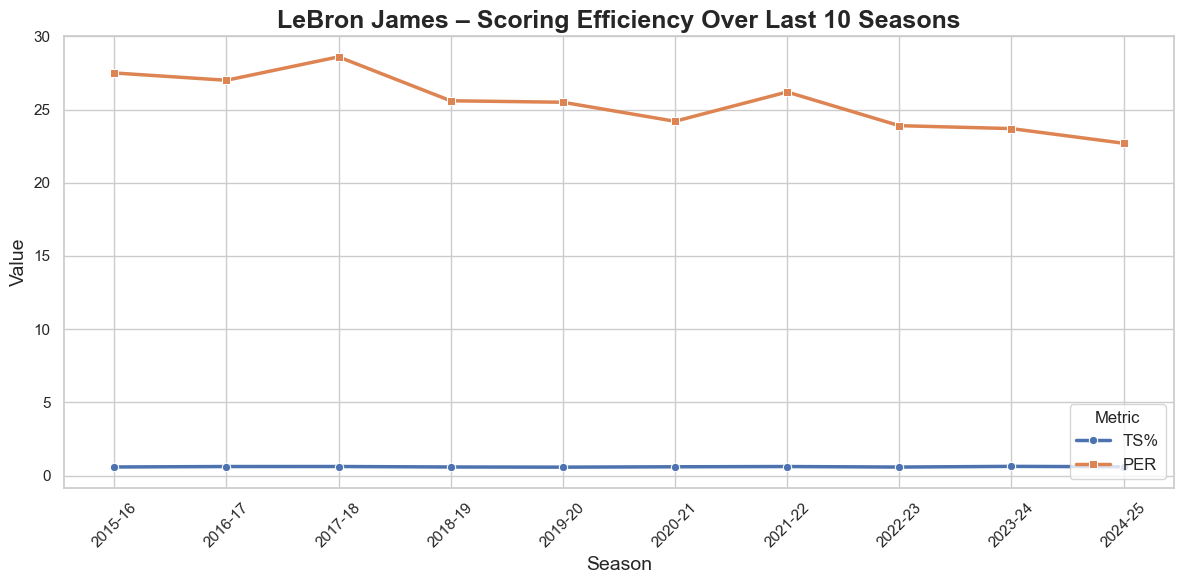

In [196]:
#Create a figure and axis
plt.figure(figsize=(12, 6))

#Plot TS%
sns.lineplot(data=lebron_cleaned, x='Season', y='TS%', marker='o', label='TS%', linewidth=2.5)

#Plot PER
sns.lineplot(data=lebron_cleaned, x='Season', y='PER', marker='s', label='PER', linewidth=2.5)

#Titles and labels
plt.title("LeBron James – Scoring Efficiency Over Last 10 Seasons", fontsize=18, weight='bold')
plt.xlabel("Season", fontsize=14)
plt.ylabel("Value", fontsize=14)
plt.xticks(rotation=45)
plt.legend(title="Metric", loc='lower right', fontsize=12)
plt.tight_layout()
plt.show()

### <u>Answer:</u> LeBron's True Shooting Percentage has remained at a near constant level. His Personal Efficiency Rating has dropped.

## 2. Which teams in the eastern conference had the best win-lose percentage and how does it correlate with opponent points per game?
* Use dataframe: conference
### Create a scatter plot
* Create a figure and axis
* Plot a line of regression to establish a trend in the data
* Plot W/L%
* Plot PA/G
* Color by team
* Create a graph title
* Create x-axis and y-axis labels
* Create layout (hide legend for readability)
* Show plot

In [234]:
conference

,Team,W/L%,PA/G
0,Cleveland Cavaliers,0.780,112.4
1,Boston Celtics,0.744,107.2
2,New York Knicks,0.622,111.7
3,Indiana Pacers,0.610,115.1
4,Milwaukee Bucks,0.585,113.0
5,Detroit Pistons,0.537,113.6
6,Orlando Magic,0.500,105.5
7,Atlanta Hawks,0.488,119.3
8,Chicago Bulls,0.476,119.4
9,Miami Heat,0.451,110.0


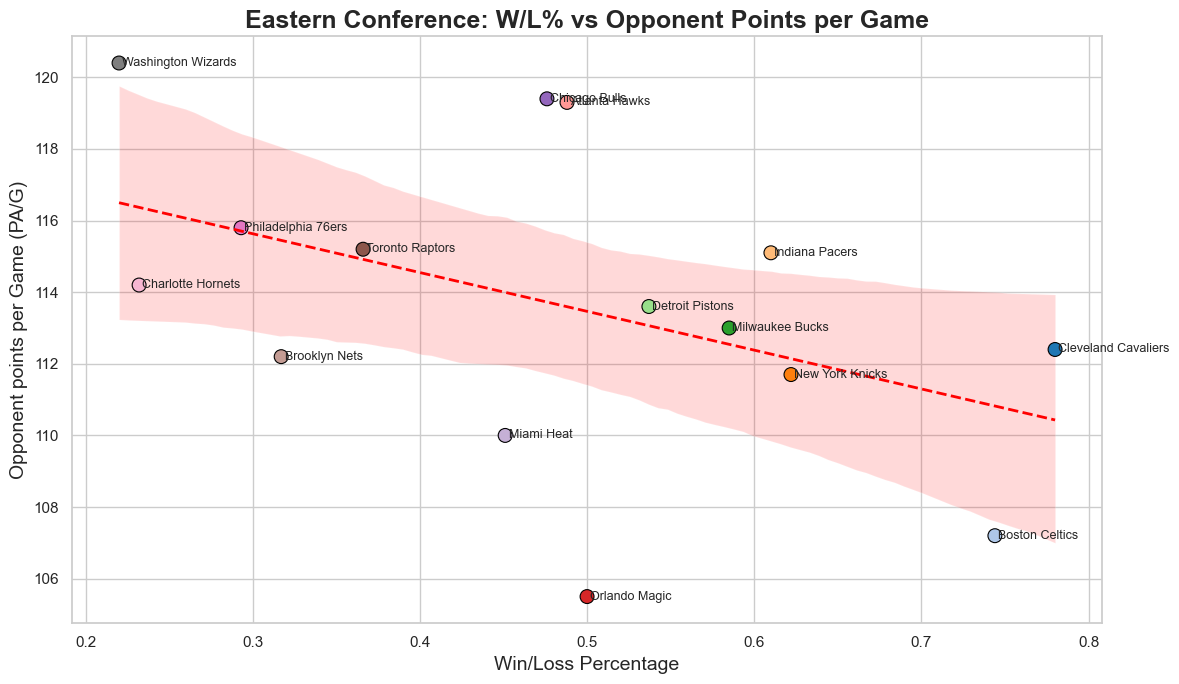

In [235]:
#Initialize plot
plt.figure(figsize=(12, 7))

#Regression line (without scatter points)
sns.regplot(
    data=conference,
    x='W/L%',
    y='PA/G',
    scatter=False,
    line_kws={"color": "red", "linewidth": 2, "linestyle": "--"}
)

#Scatter plot with team names as color
scatter = sns.scatterplot(
    data=conference,
    x='W/L%',
    y='PA/G',
    hue='Team',
    palette='tab20', 
    s=100,  #Point size
    edgecolor='black'
)

# Add annotations (optional)
for i, row in conference.iterrows():
    plt.text(row['W/L%'] + 0.002, row['PA/G'], row['Team'], fontsize=9, ha='left', va='center')

#Titles and labels
plt.title("Eastern Conference: W/L% vs Opponent Points per Game", fontsize=18, weight='bold')
plt.xlabel("Win/Loss Percentage", fontsize=14)
plt.ylabel("Opponent points per Game (PA/G)", fontsize=14)

#Layout
plt.legend([],[], frameon=False)  #Hide legend (use text labels instead)
plt.tight_layout()
plt.show()

### <u>Answer:</u> The Cleveland Cavaliers and Boston Celtics had the best win-lose percentage in the Eastern Conference.
* Opponent Points per Game appear to have a weakly negative correlation with Win/Loss Percentage.
* As Win/Loss Percentage increases to the right, Opponent Points per Game generally go down.
* The Cleveland Cavaliers had the highest Win-Loss Percentage, but not the lowest Opponent Points per Game. This means that other teams did not allow opponents to score as many points, yet those teams have a lower win/loss percentage.
* The Boston Celtics has the second-highest win/loss percentage, but not the lowest opponent points per game.
####  <u>Conclusion:</u> While the Cleveland Cavaliers have the highest overall win-loss percentage (strongest offense), Orlando Magic has the lowest opponent points per game (strongest defense).
#### There appears to be a weakly negative relationship between Opponent Points per Game and Win/Loss Percentage

## 3. In the 2024-25 season, how does the Lakers' performance compare to their opponents? Judge stats like field goal percentage, total rebounds, and total points.
* Use dataframe: lakers_vs
#### Create a graph
* Melt the dataframe for plotting
* Set the figure size
* Create a barplot with stats and values, colored by team
* Title the graph
* Add Y axis title
* Add X axis title
* Iterate in .patches to show the exact values on top of each bar
* Display the graph


In [236]:
lakers_vs

,Team,FG%,TRB,PTS
0,Lakers,0.479,3479,9298
4,Opponent,0.463,3528,9198


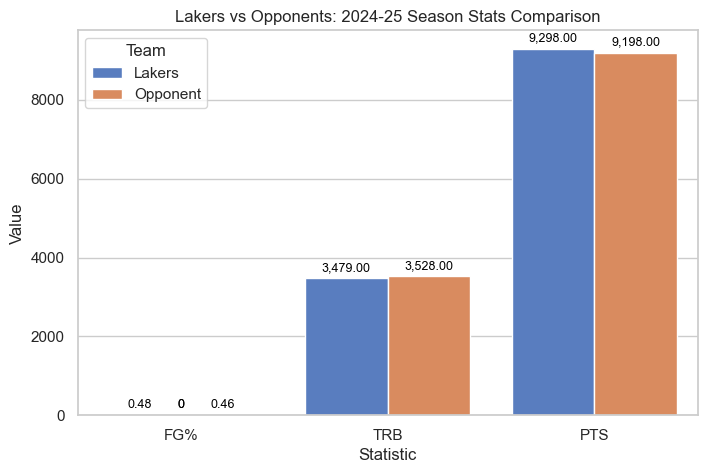

In [237]:
#Melt the dataframe to long format for seaborn plotting
lakers_long = lakers_vs.melt(id_vars='Team', var_name='Stat', value_name='Value')

#Plot
plt.figure(figsize=(8,5))
barplot = sns.barplot(data=lakers_long, x='Stat', y='Value', hue='Team', palette='muted')

# Add title and labels
plt.title("Lakers vs Opponents: 2024-25 Season Stats Comparison")
plt.ylabel("Value")
plt.xlabel("Statistic")

#Show exact values on top of bars
for p in barplot.patches:
    height = p.get_height()
    barplot.annotate(f'{height:,.2f}' if isinstance(height, float) else f'{int(height)}',
                     (p.get_x() + p.get_width() / 2., height),
                     ha='center', va='bottom', fontsize=9, color='black', xytext=(0,3),
                     textcoords='offset points')

#Display the graph
plt.show()

### <u>Answer:</u> The Lakers had a slightly higher Field Goal Percentage, lower Total Rebounds, and higher Points than their opponents in the 2024-25 Season.

## 4. Which coaches of the 2024-2025 season had the highest win ratio?
* Use dataframe: coaches2
### Use columns:
* Coach
* W/L%
## Plot the graph
* Create a figure size
* Create a bar plot
* Add value labels to bars by iterating through the win-loss percentage
* Create a graph title
* Create an x-axis title
* Create a y-axis title
* Use tight_layout so all graph elements are visible
* Show the graph

In [253]:
coaches2

,Coach,W,L,W/L%
0,David Adelman,3,0,1.00
1,Mark Daigneault,68,14,0.83
2,Kenny Atkinson,64,18,0.78
3,Joe Mazzulla,61,21,0.74
4,Ime Udoka,52,30,0.63
5,Tom Thibodeau,51,31,0.62
6,Tyronn Lue,50,32,0.61
7,JJ Redick,50,32,0.61
8,Rick Carlisle,50,32,0.61
9,Taylor Jenkins,44,29,0.60


C:\Users\pmost\AppData\Local\Temp\ipykernel_18404\2836866617.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


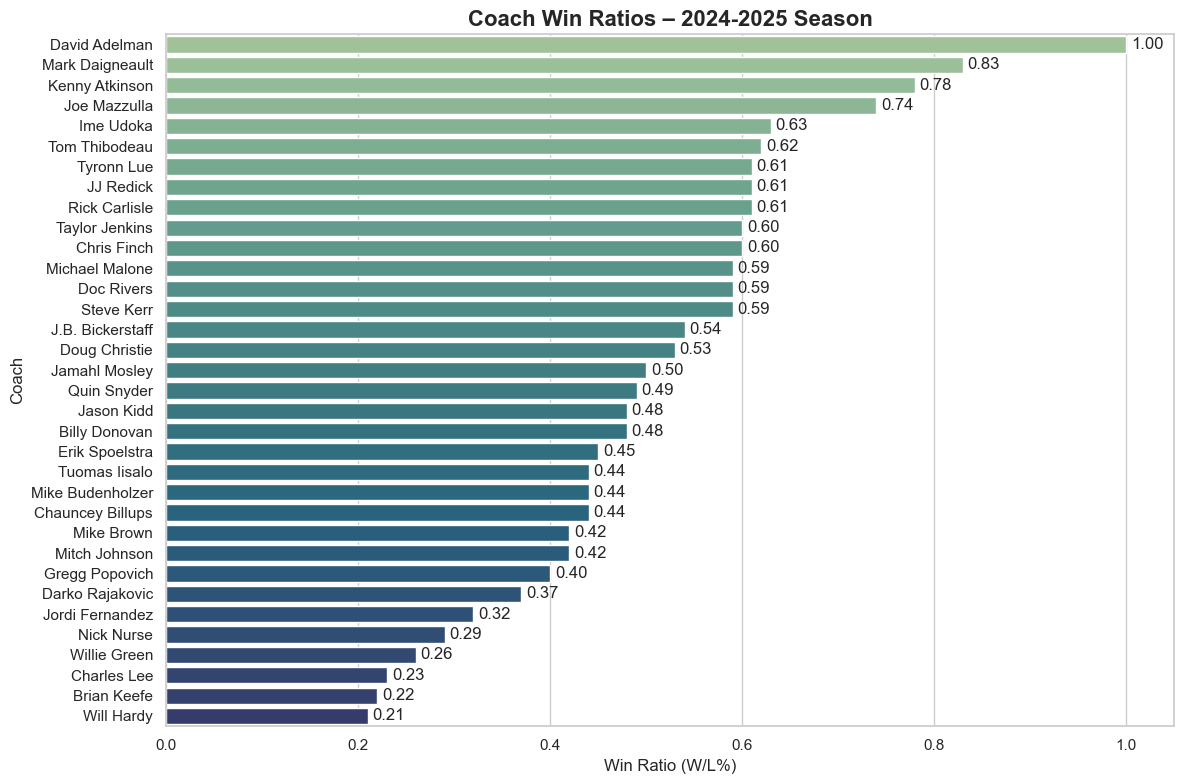

In [255]:
#Create figure
plt.figure(figsize=(12, 8))
barplot = sns.barplot(
    data=coaches2,
    y='Coach',
    x='W/L%',
    palette='crest'  # try 'Blues', 'viridis', 'mako', 'flare', etc.
)

#Add value labels to bars
for i, (value) in enumerate(coaches2['W/L%']):
    plt.text(value + 0.005, i, f'{value:.2f}', va='center')

#Title and labels
plt.title("Coach Win Ratios – 2024-2025 Season", fontsize=16, weight='bold')
plt.xlabel("Win Ratio (W/L%)", fontsize=12)
plt.ylabel("Coach", fontsize=12)

#Display the graph
plt.tight_layout()
plt.show()

### <u>Answer:</u> David Adelman, Mark Daigneault, Kenny Atkinson, and Joe Mazzulla had the highest win ratio out of the 2024-25 Season coaches.

## 5. What impact do the top 10 points per game 2024 draft members have on their team wins? Assess points per game (PTS), assists (AST), and win shares (WS) among the top 10 points-per-game draft players. 
* Use dataframe: top_10_draft
### Use columns:
* Player
* PTS
* AST
* WS
## Plot the graph
* Create a figure size
* Melt the dataframe to graph several statistics
* Create the barplot
* Create a graph title
* Create an x-axis title
* Create a y-axis title
* Create a legend to color by statistics
* Use tight_layout so all graph elements are visible
* Show the graph

In [256]:
top_10_draft.columns

Index(['Player', 'PTS', 'AST', 'WS'], dtype='object')

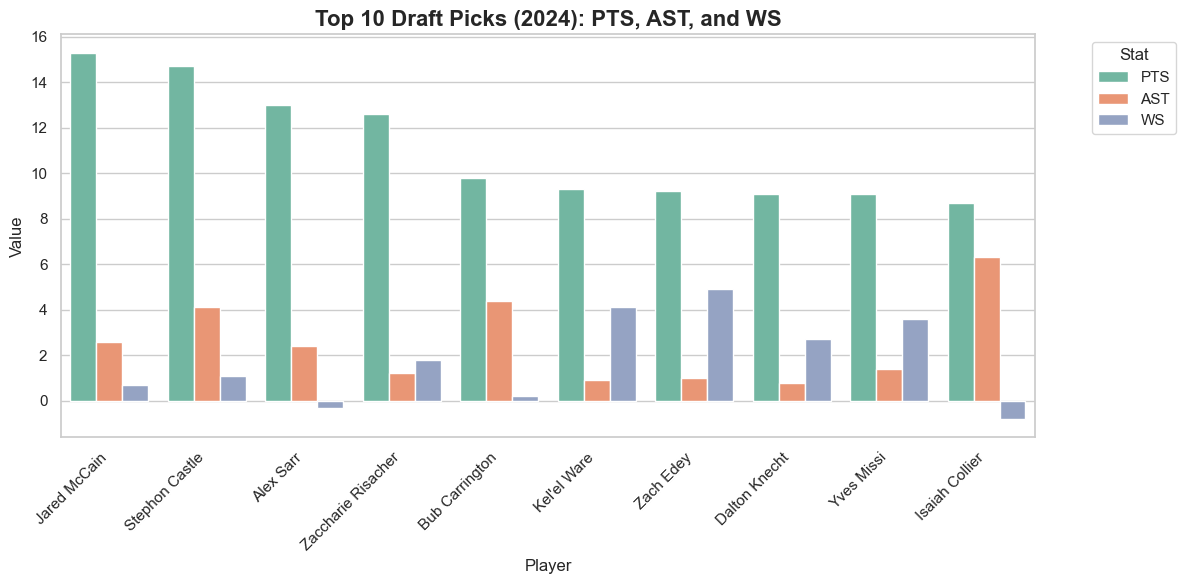

In [258]:
#Set the figure size
plt.figure(figsize=(12, 6))

#Melt the DataFrame to long format
top_10_melted = top_10_draft.melt(
    id_vars="Player", 
    value_vars=["PTS", "AST", "WS"], 
    var_name="Stat", 
    value_name="Value"
)

#Create the barplot
sns.barplot(
    data=top_10_melted,
    x="Player",
    y="Value",
    hue="Stat",
    palette="Set2"
)

#Add titles and labels
plt.title("Top 10 Draft Picks (2024): PTS, AST, and WS", fontsize=16, weight='bold')
plt.xlabel("Player", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title="Stat", bbox_to_anchor=(1.05, 1), loc='upper left')

#Layout
plt.tight_layout()

#Display graph
plt.show()

### <u>Answer:</u> The top 10 points per game 2024 draft members have an unclear impact on their team wins.
* Generally, it appears that the highest points-scoring players have the lowest win-share percentages.
* This suggests a weak inverse relationship between points scored and win-shares.
* Assists do not have a clear relation to either points scored or win-shares.